In [2]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
#from src.data import words_clusters

In [3]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_movies = pd.read_csv(DATA + 'ratings_movies.csv', sep=',')
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

In [4]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [5]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [6]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

In [7]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [8]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [9]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [10]:
# remove ' (yyyy)' from df_ratings_movies titles including any white spaces before parenthesis
df_ratings_movies['title'] = df_ratings_movies['title'].apply(cleaning.clean_titles)

In [11]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

In [12]:
# retrieving mean ratings
mean_ratings = df_ratings_ratings.groupby(df_ratings_ratings["movieId"]).mean()
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

In [13]:
# binning ratings to match viewers regular rating style (.5 vote scale)
df_movies_tmdb_ratings['mean_rating_binned'] = df_movies_tmdb_ratings.mean_rating.mul(2).round().div(2)

In [14]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

In [16]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [17]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

In [18]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

In [19]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [20]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# Regions

In [51]:
df_countries_regional = pd.read_csv(DATA + 'countries_by_continent.csv')  # Load region info

# Merge with the regional data based on the single country names
df_movies_TMDB_ratings = pd.merge(
    df_movies_tmdb_ratings,
    df_countries_regional,
    left_on='countries',
    right_on='country',
    how='left' 
)

# Drop 'country' from the regional dataset to avoid redundancy
df_movies_TMDB_ratings = df_movies_TMDB_ratings.drop(columns=['country'])

In [210]:
df_movies_ratings_regions = df_movies_TMDB_ratings.copy()
df_movies_ratings_regions['revenue'] = df_movies_ratings_regions['revenue'].fillna(0.0)

C:\Users\ac\AppData\Local\Temp\ipykernel_2080\172334302.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_movies_ratings_regions['revenue'] = df_movies_ratings_regions['revenue'].fillna(0.0)


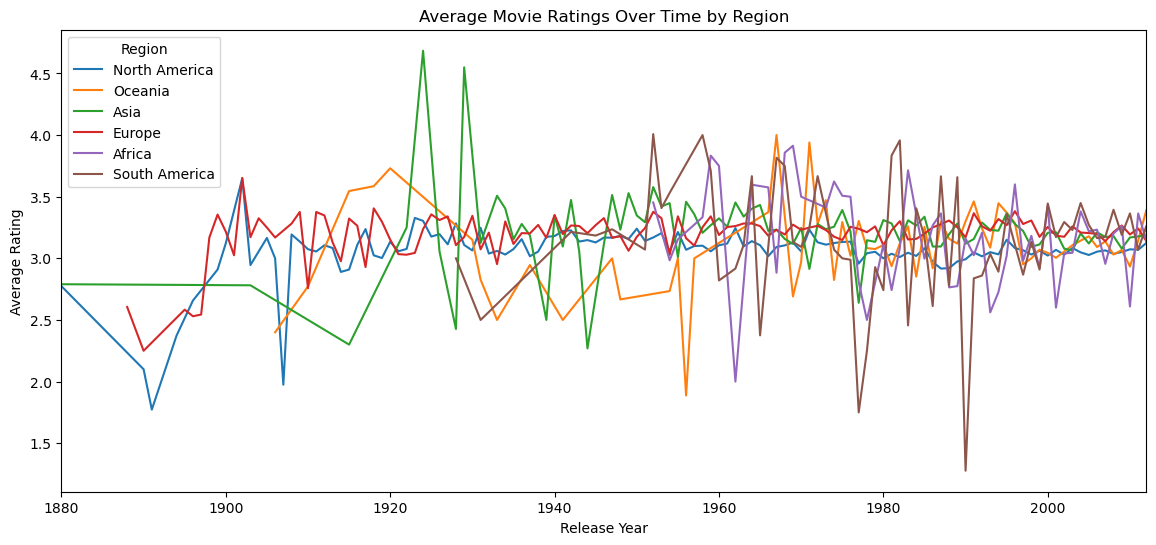

In [127]:
# Plot average ratings by release year and region
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_movies_ratings_regions, x='release_date', y='mean_rating', hue='region', estimator='mean', errorbar=None)
plt.title("Average Movie Ratings Over Time by Region")
plt.xlabel("Release Year")
plt.xlim(1880, 2012)
plt.ylabel("Average Rating")
plt.legend(title="Region")
plt.show()

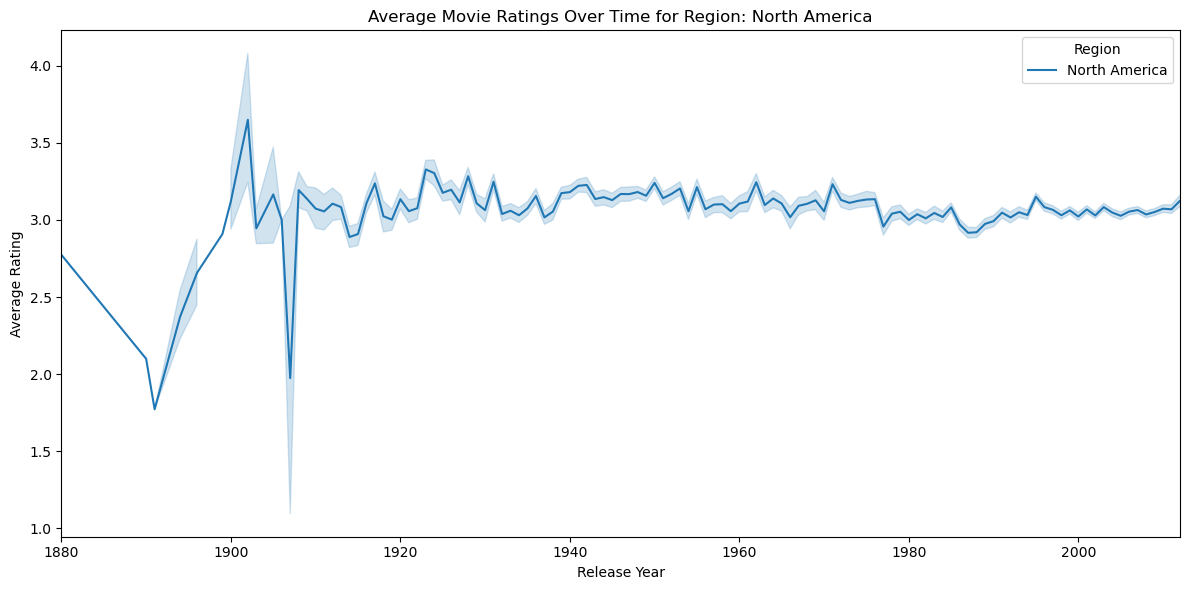

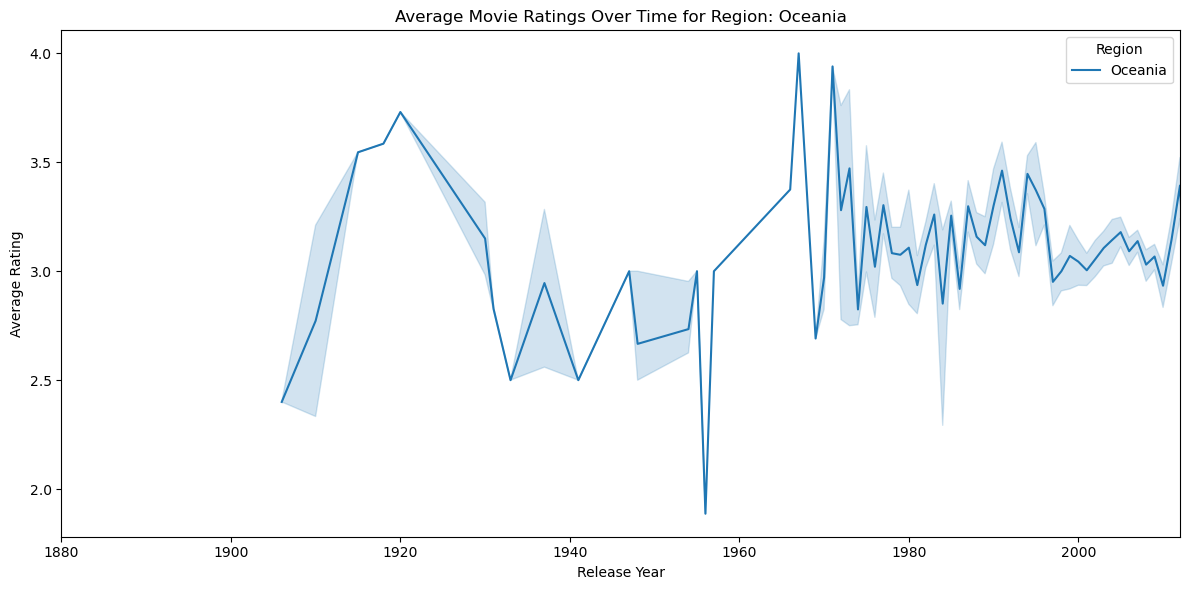

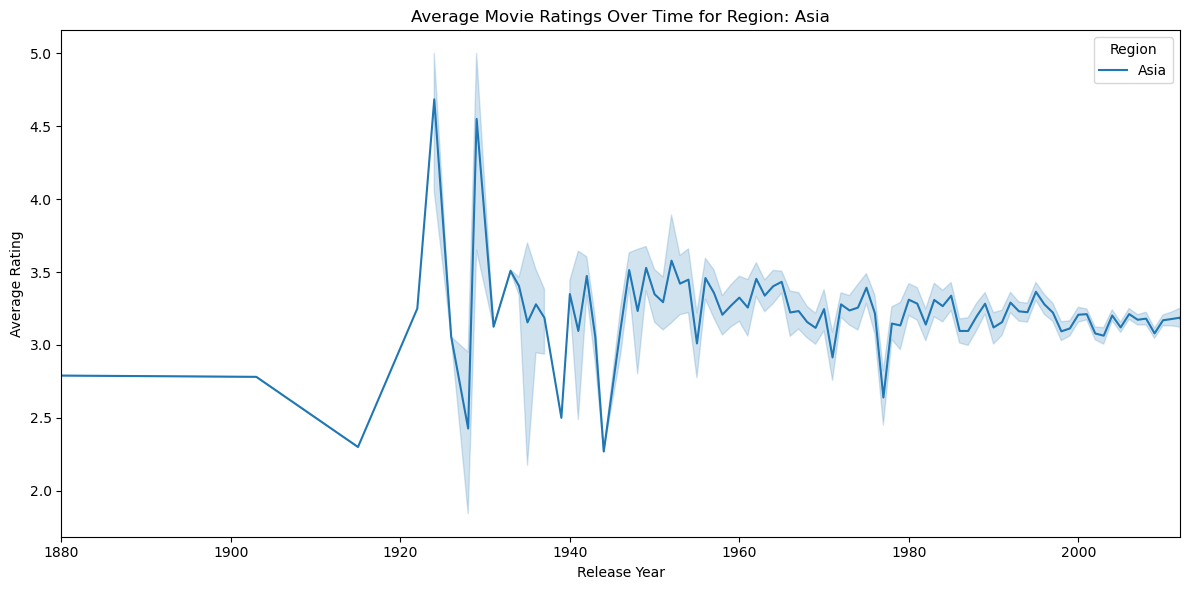

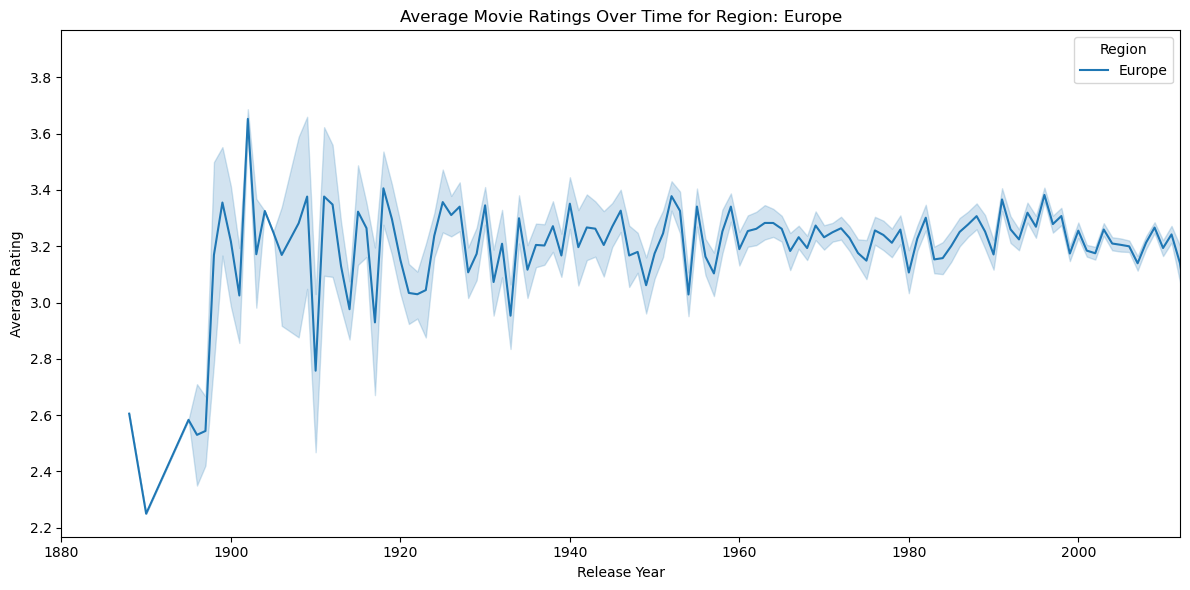

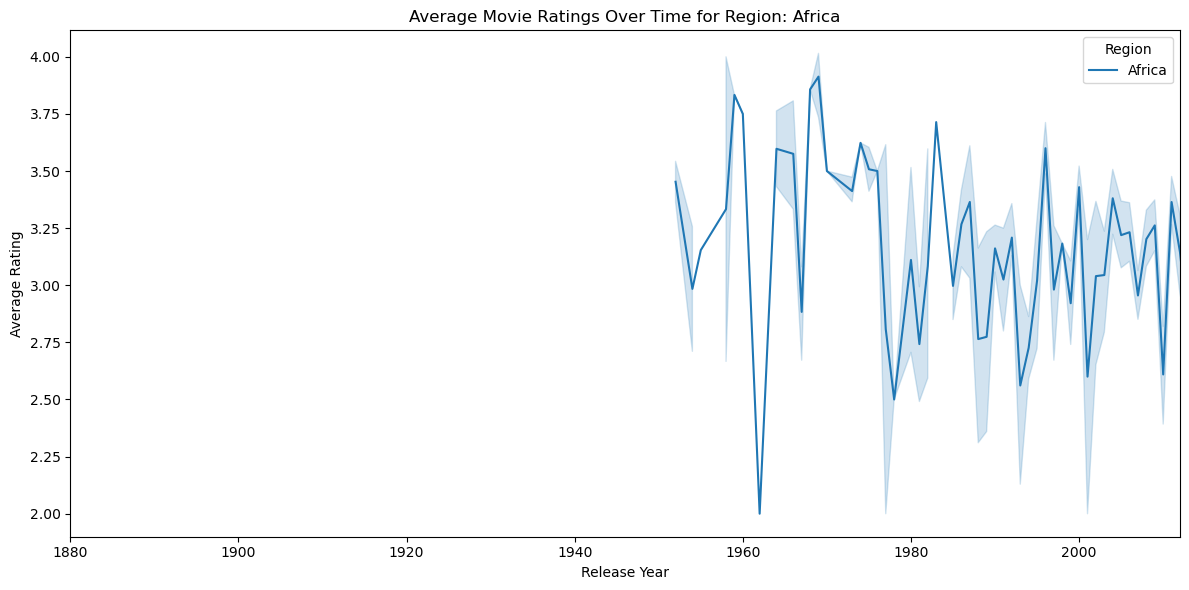

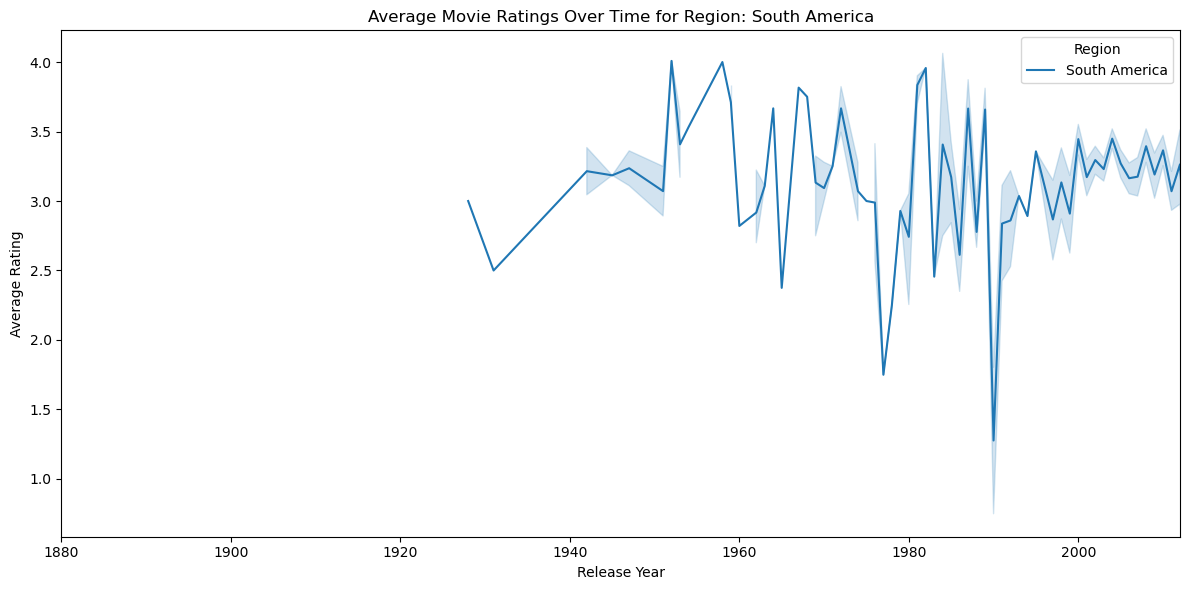

In [82]:
# Get the unique regions in the dataset
regions = df_movies_ratings_regions['region'].unique()

# Loop over the regions and create a plot for each one
for region in regions:
   
    df_region = df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_region, x='release_date', y='mean_rating', hue='region', estimator='mean')
    
    plt.title(f"Average Movie Ratings Over Time for Region: {region}")
    plt.xlabel("Release Year")
    plt.xlim(1880, 2012)
    plt.ylabel("Average Rating")
    plt.legend(title="Region")
    plt.tight_layout() 
    plt.show()

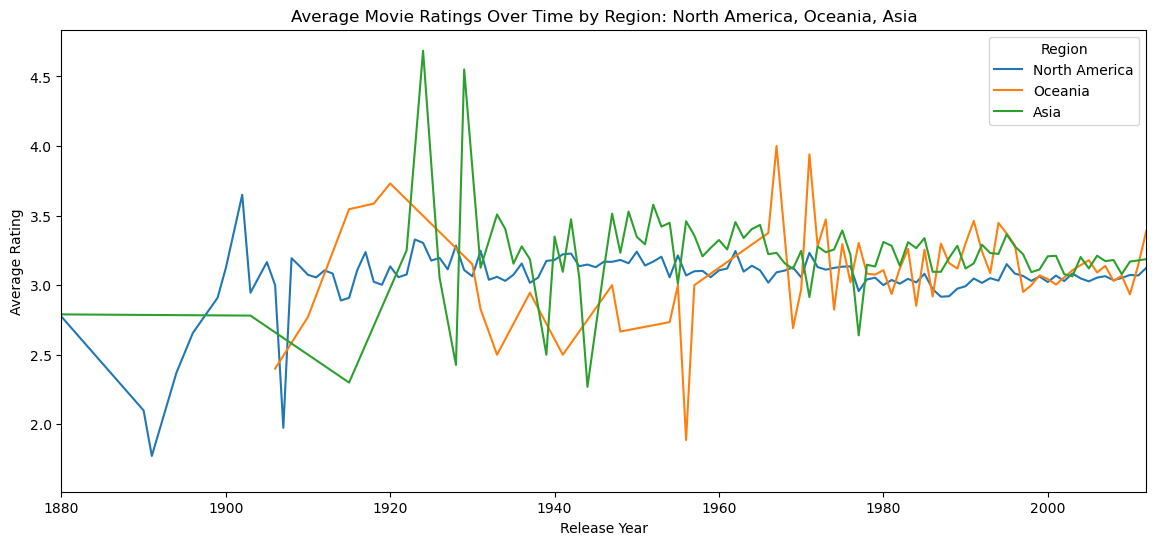

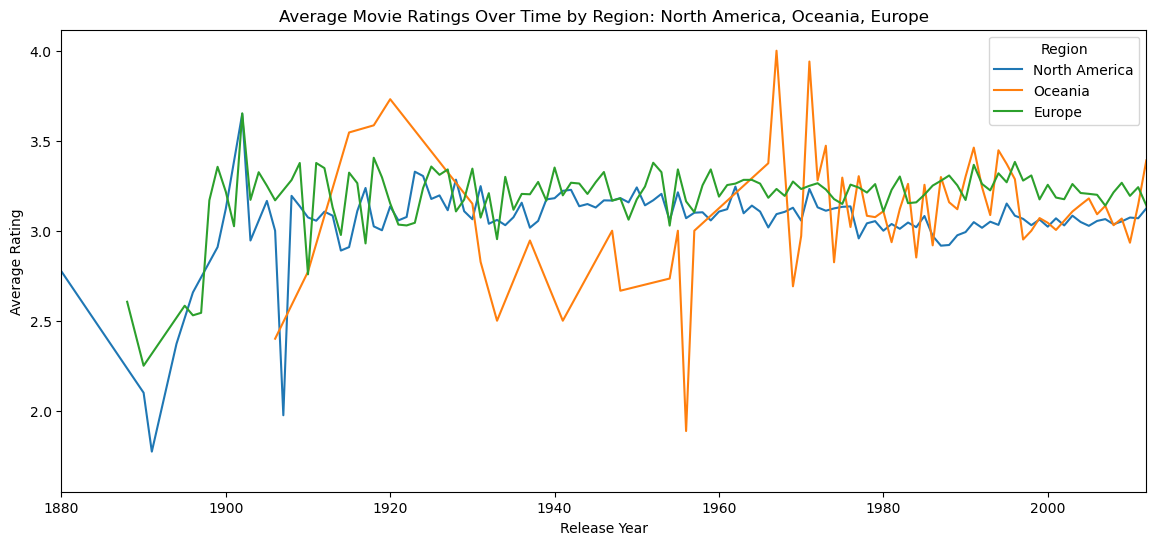

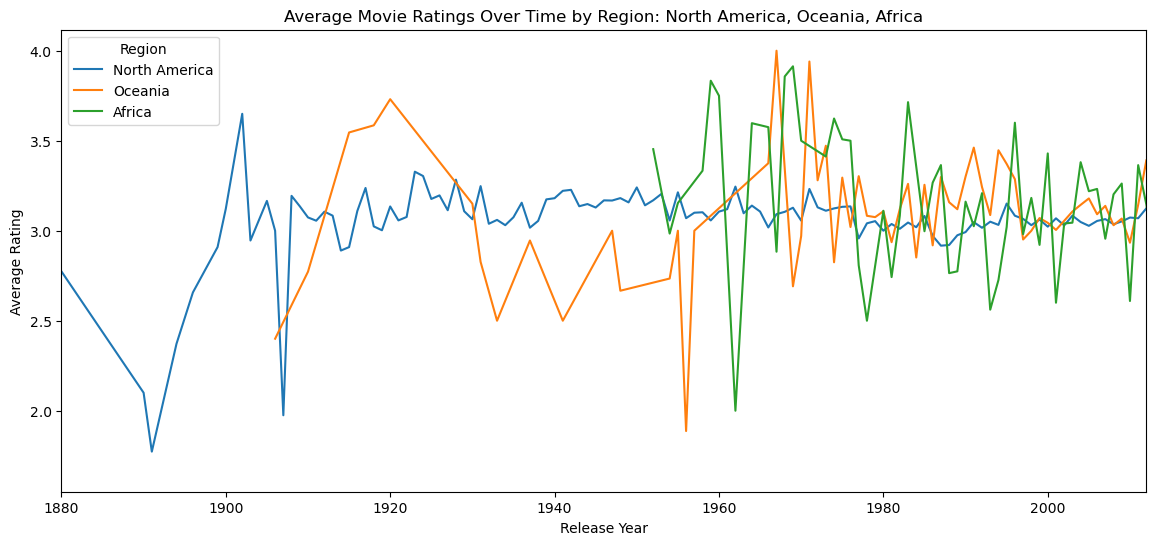

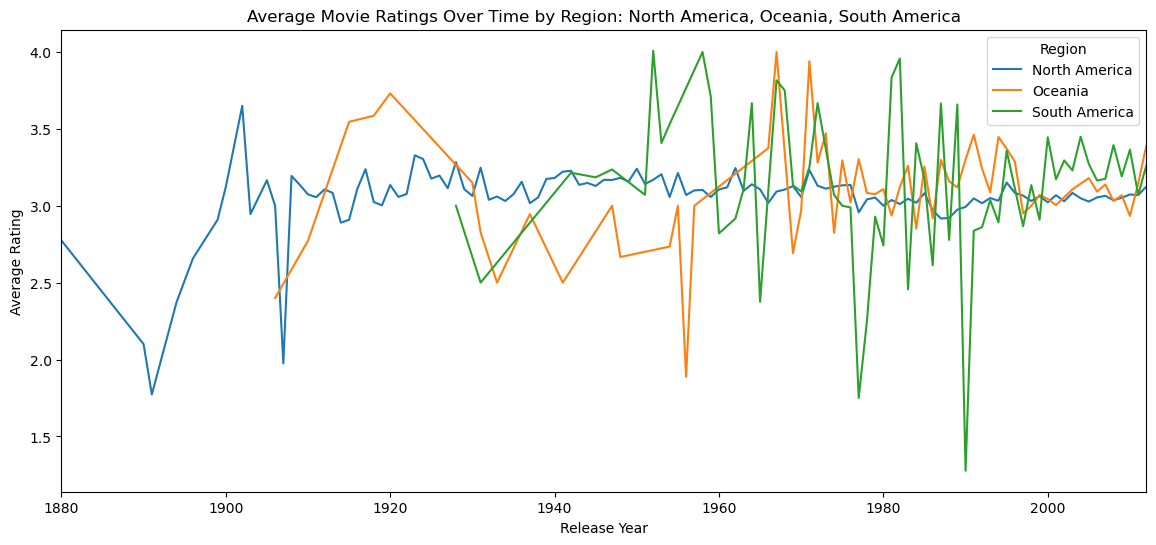

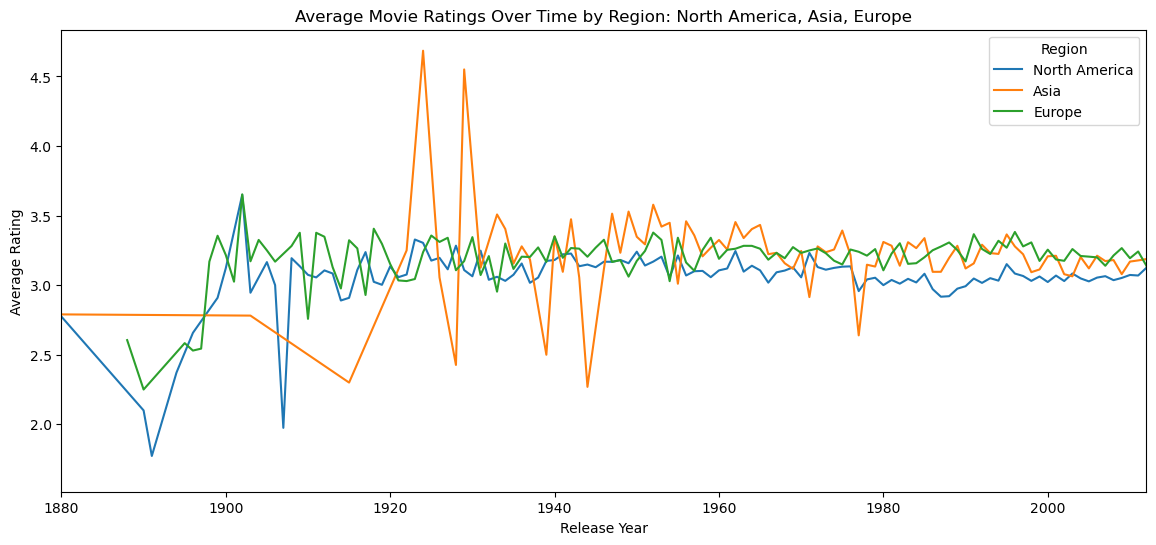

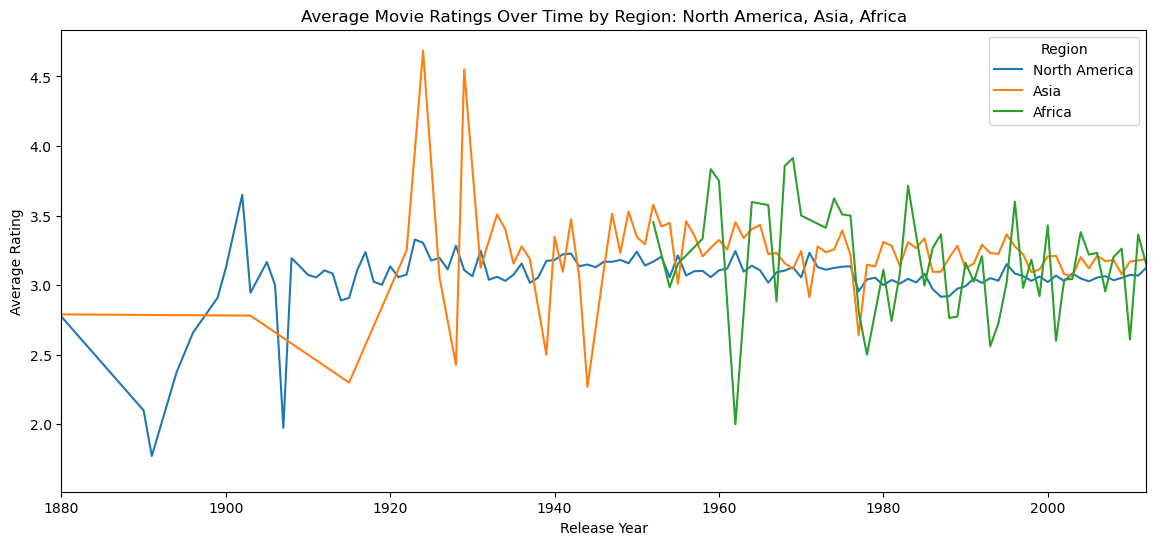

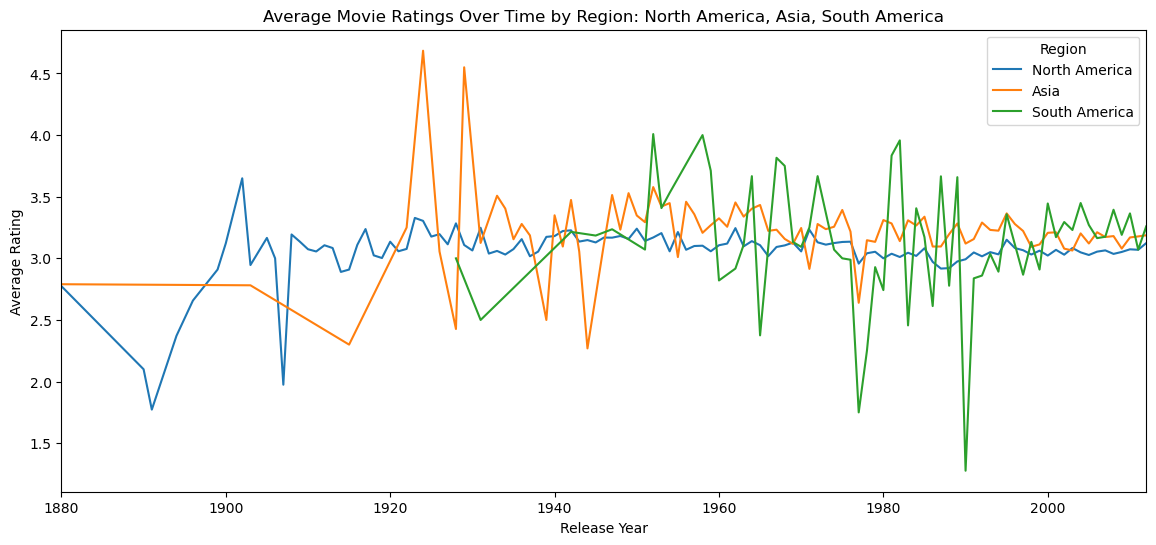

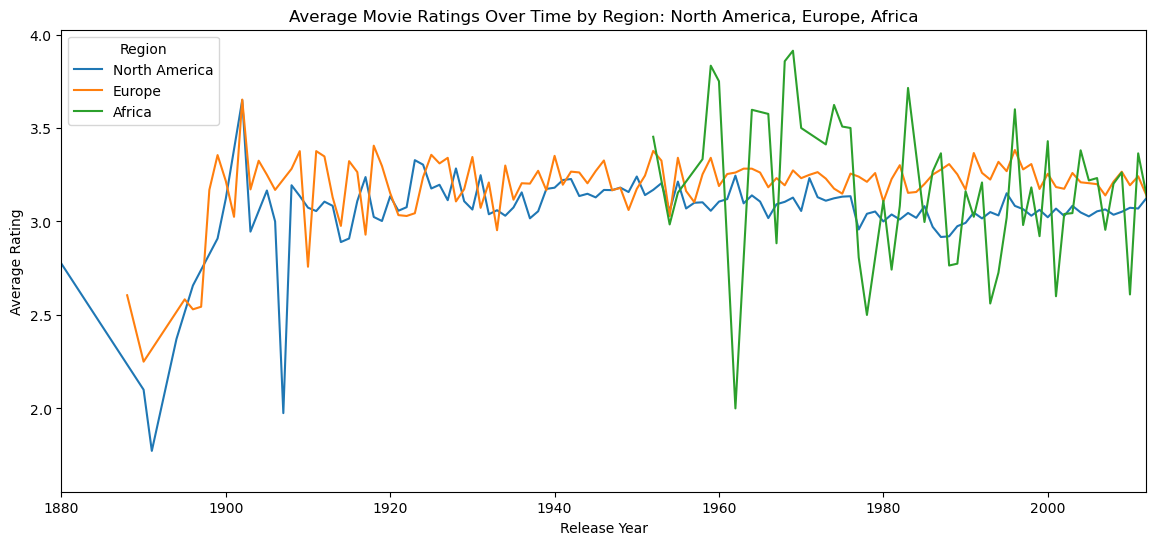

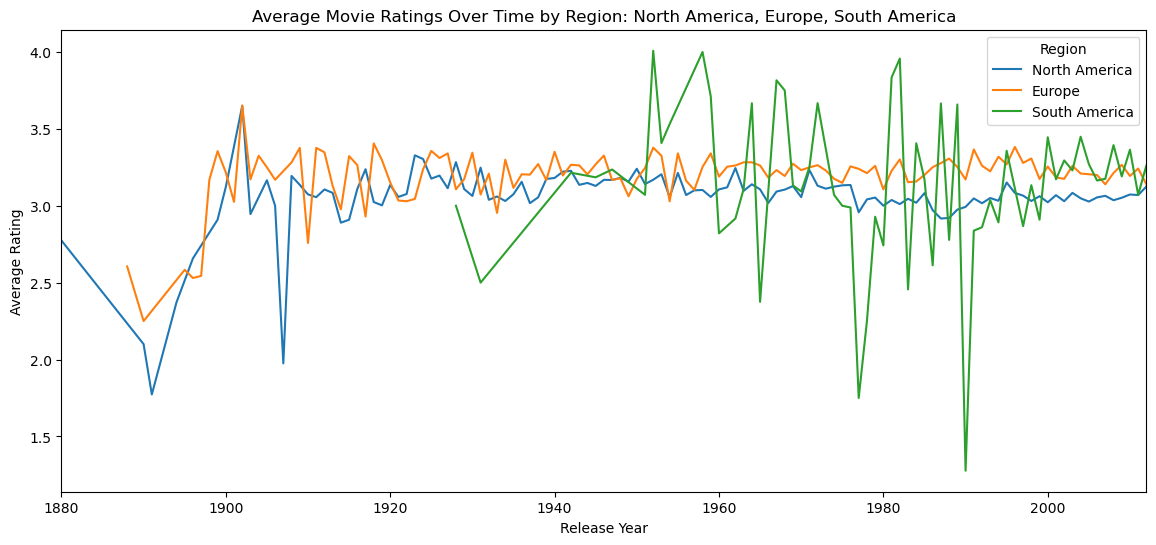

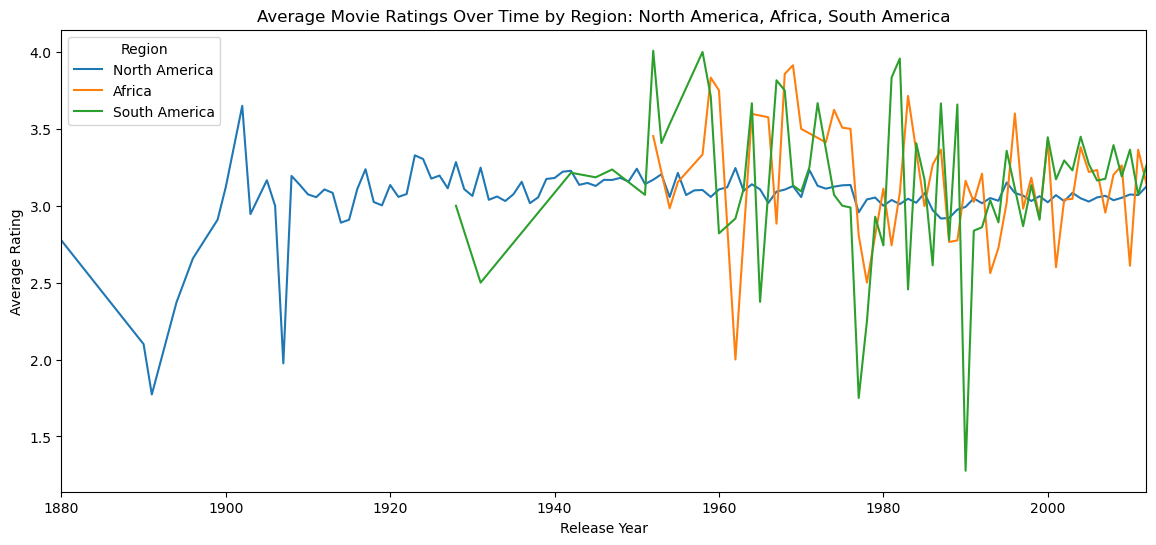

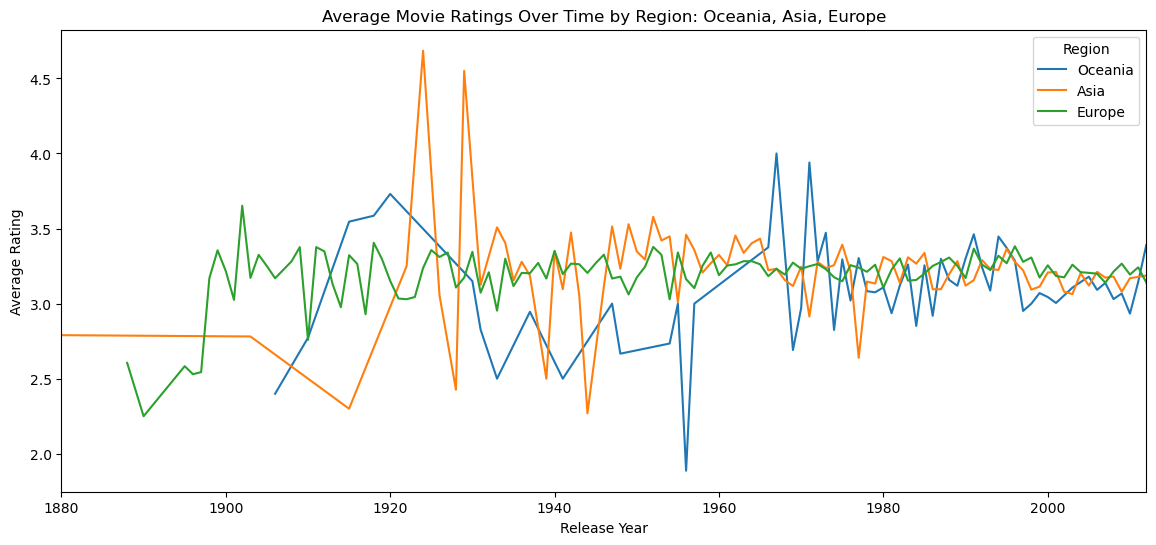

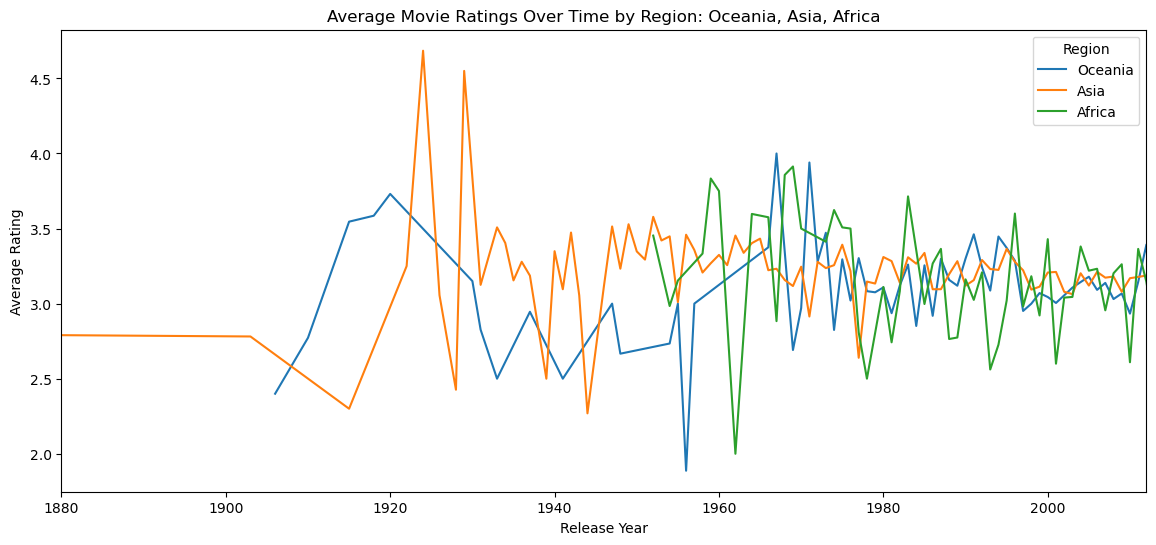

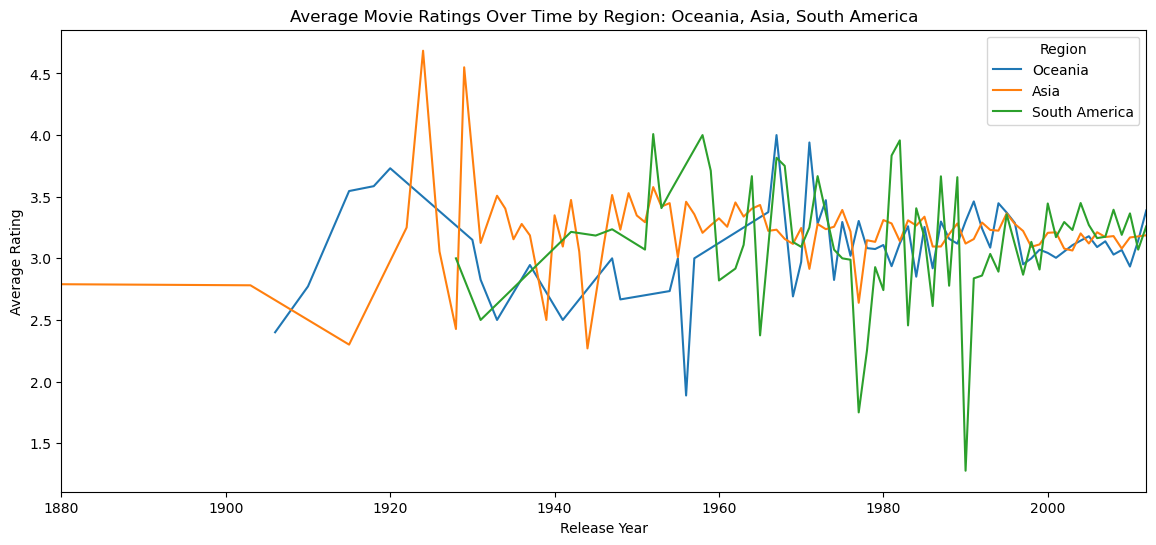

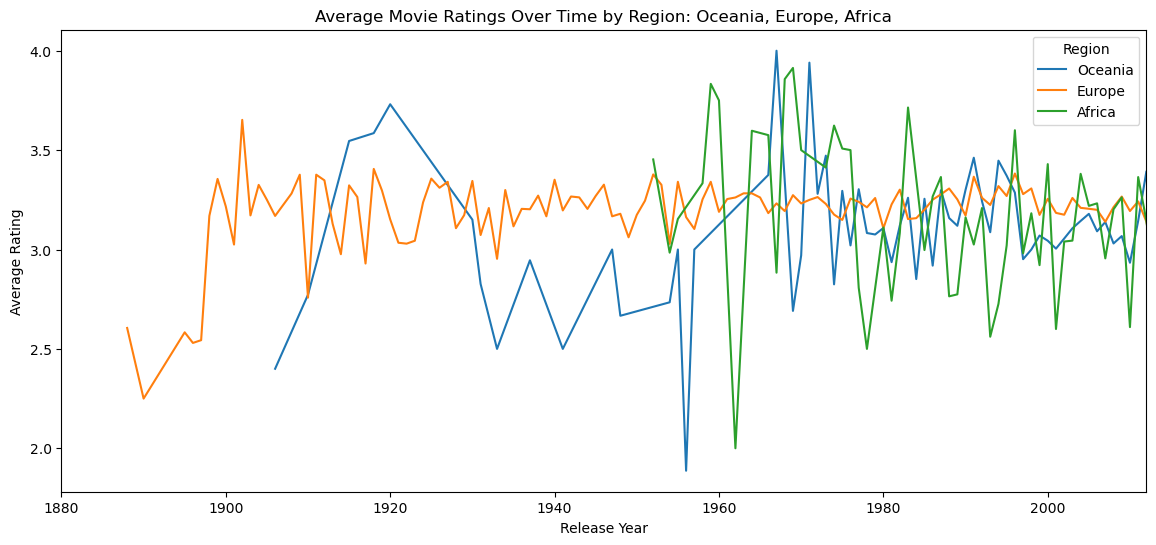

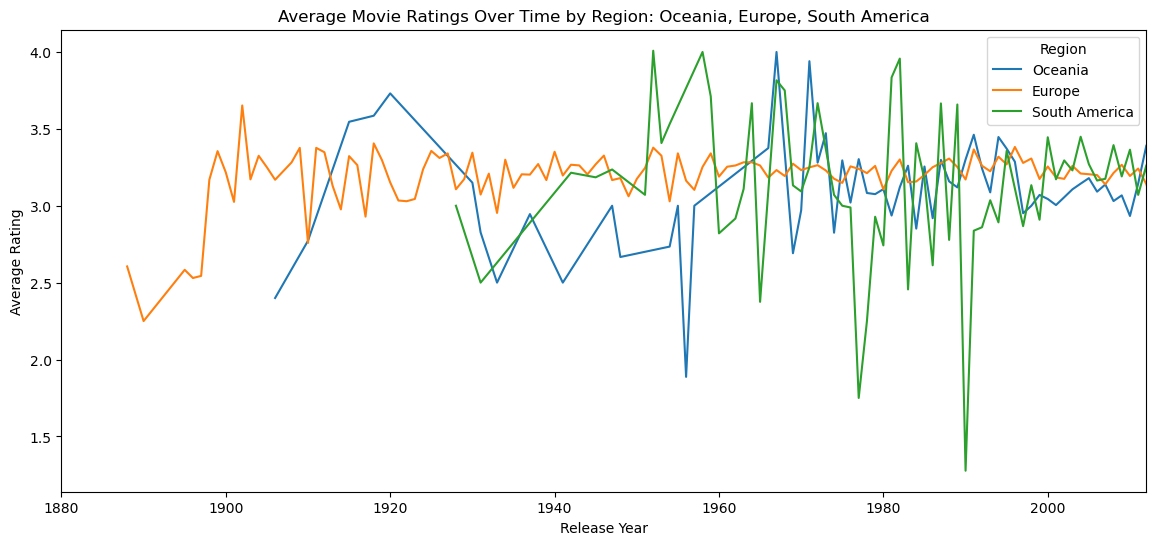

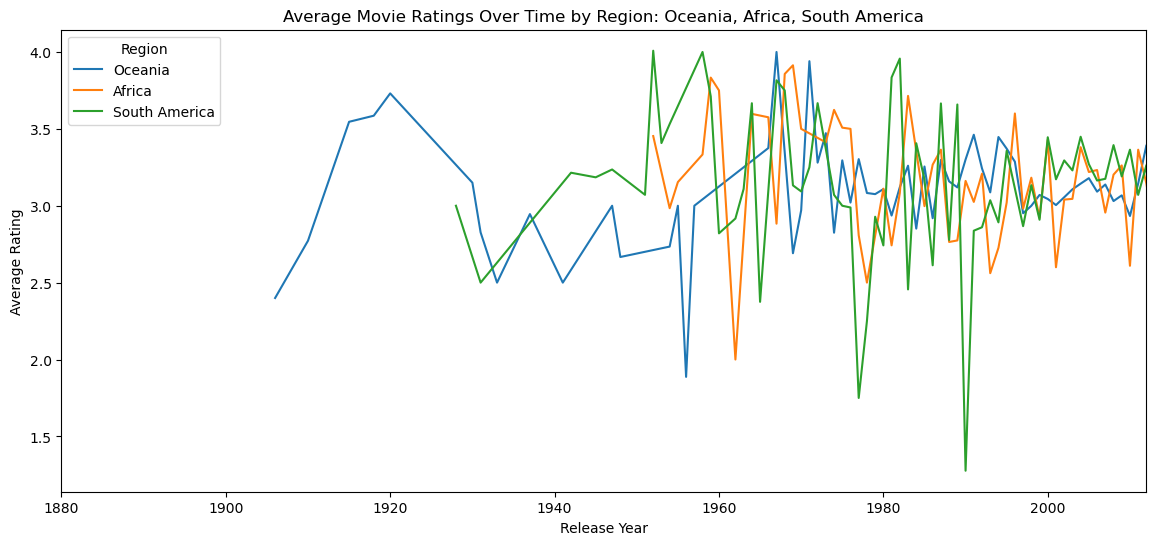

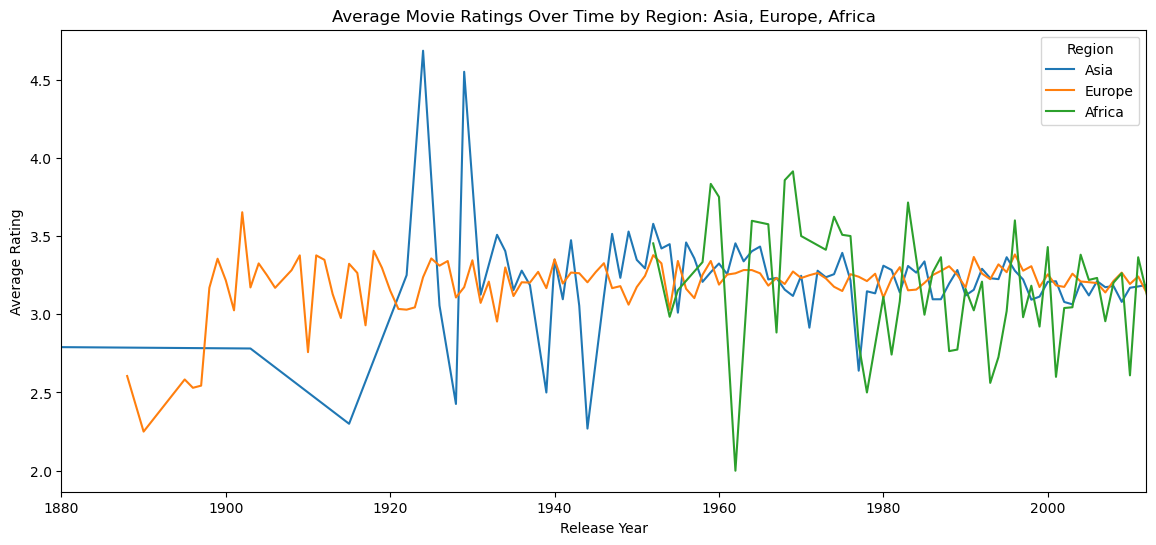

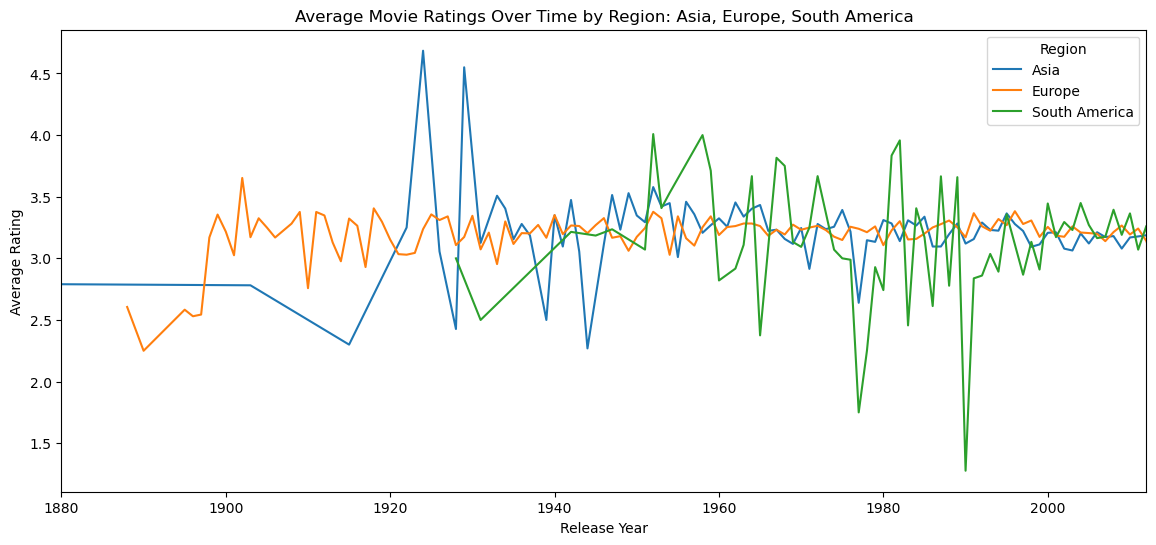

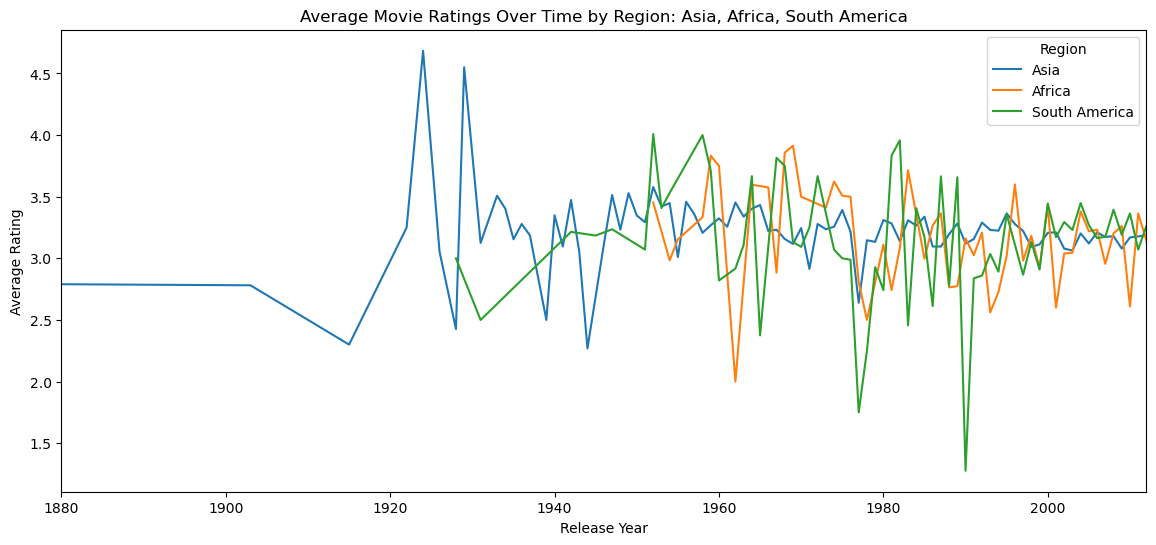

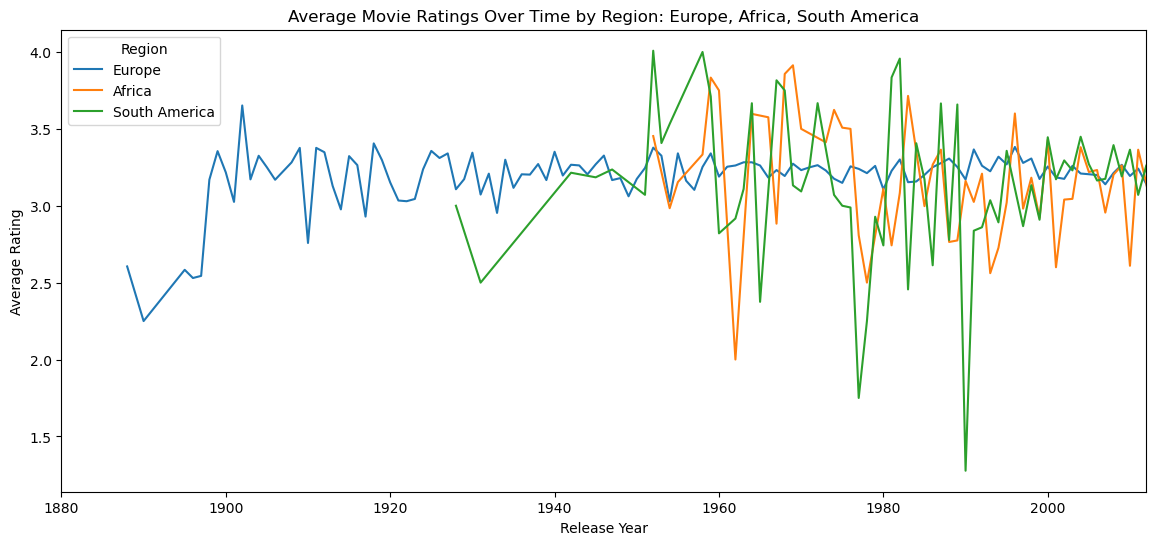

In [83]:
from itertools import combinations

# Generate combinations of 3 regions
region_combinations = list(combinations(regions, 3))

# Loop through each combination and plot
for combo in region_combinations:
    df_combo = df_movies_ratings_regions[df_movies_ratings_regions['region'].isin(combo)]
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_combo, x='release_date', y='mean_rating', hue='region', estimator='mean', errorbar=None)
    plt.title(f"Average Movie Ratings Over Time by Region: {combo[0]}, {combo[1]}, {combo[2]}")
    plt.xlabel("Release Year")
    plt.xlim(1880, 2012)
    plt.ylabel("Average Rating")
    plt.legend(title="Region")
    plt.show()

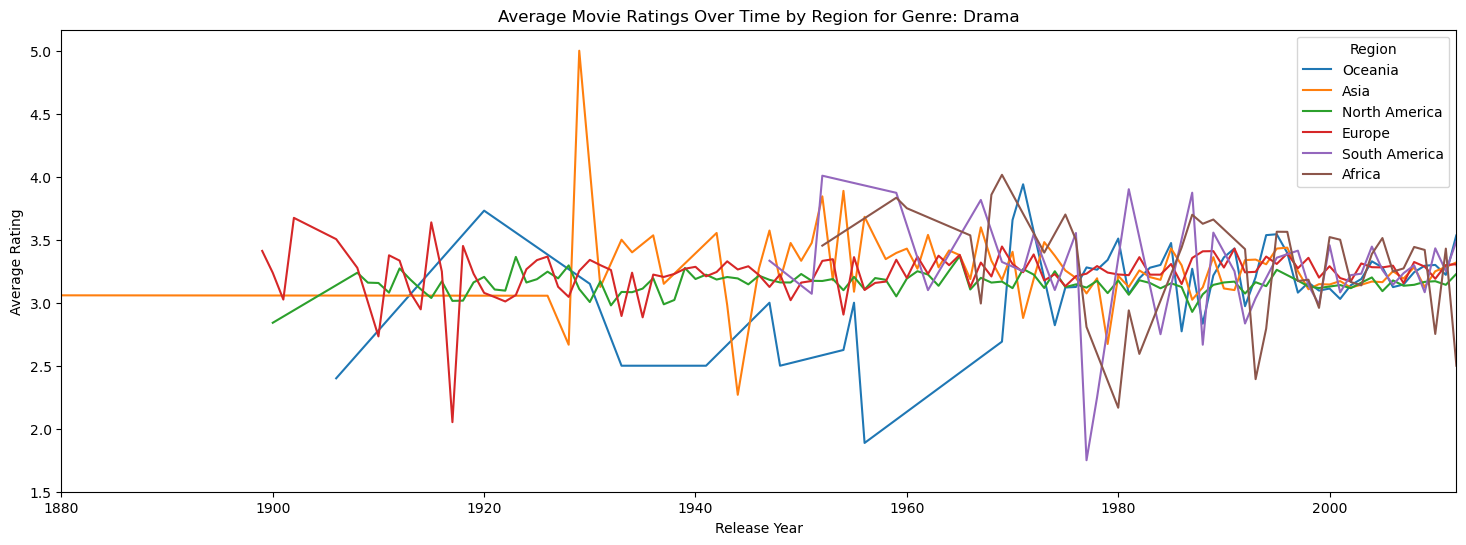

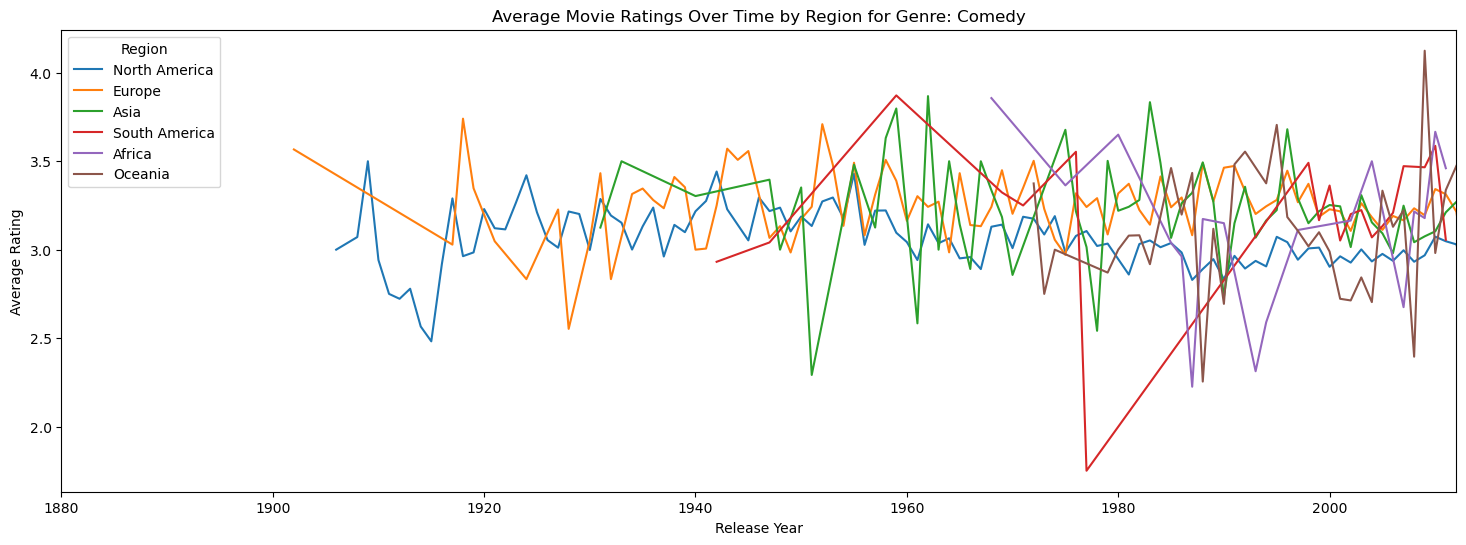

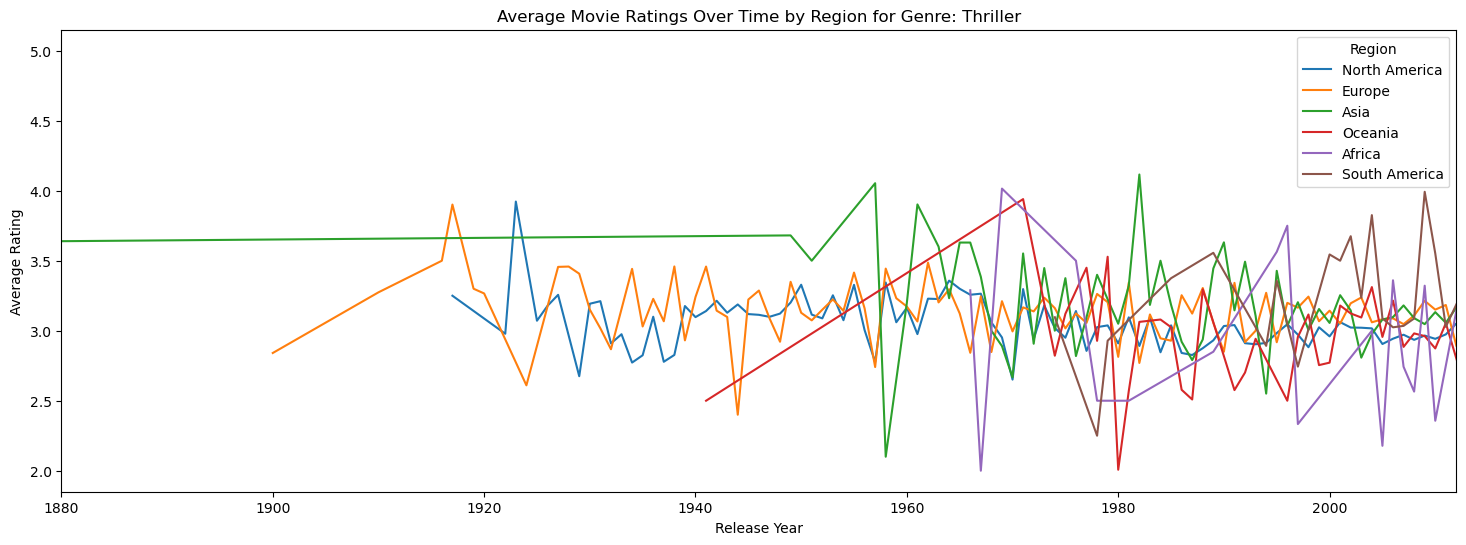

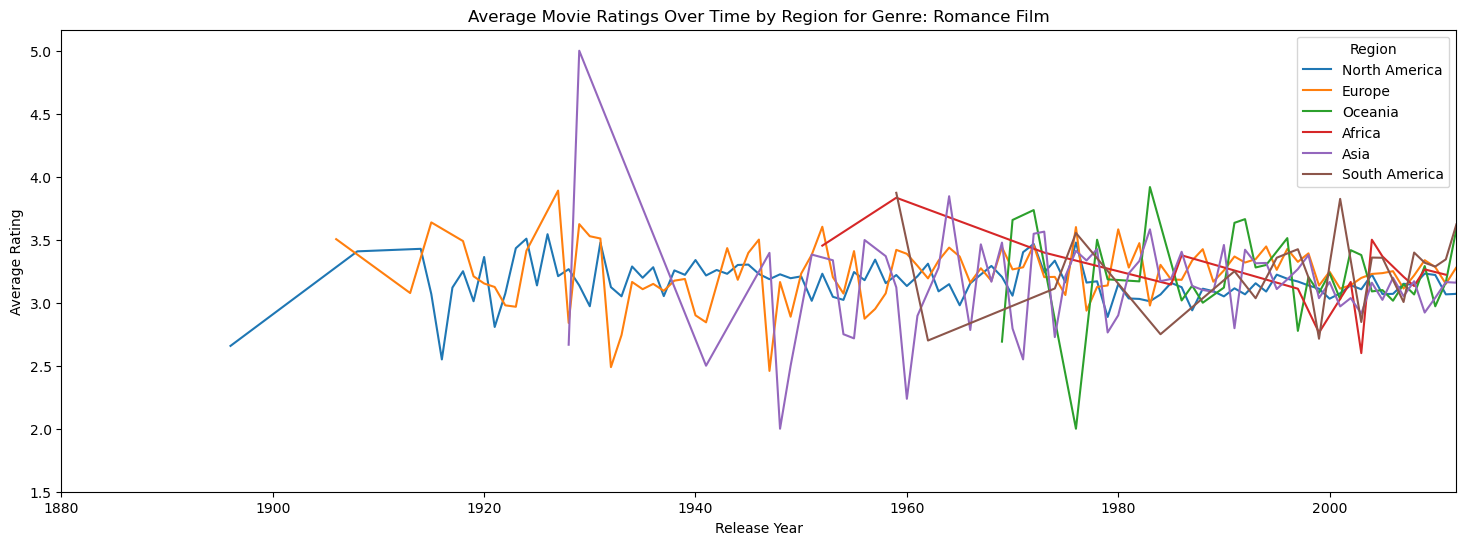

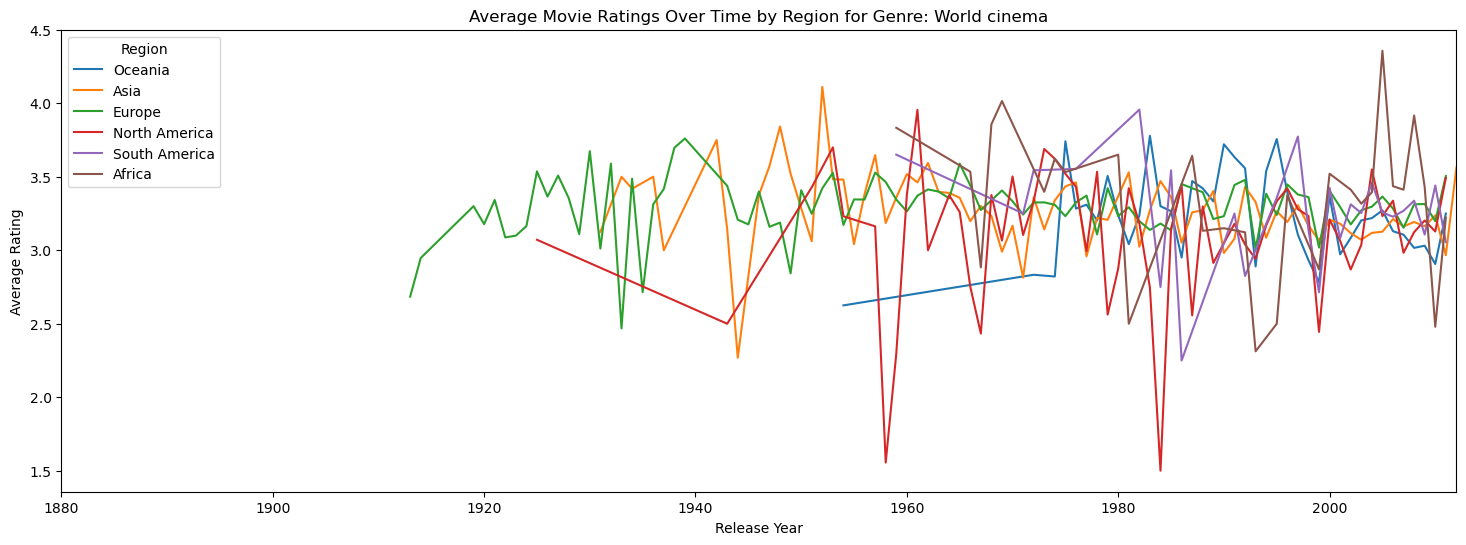

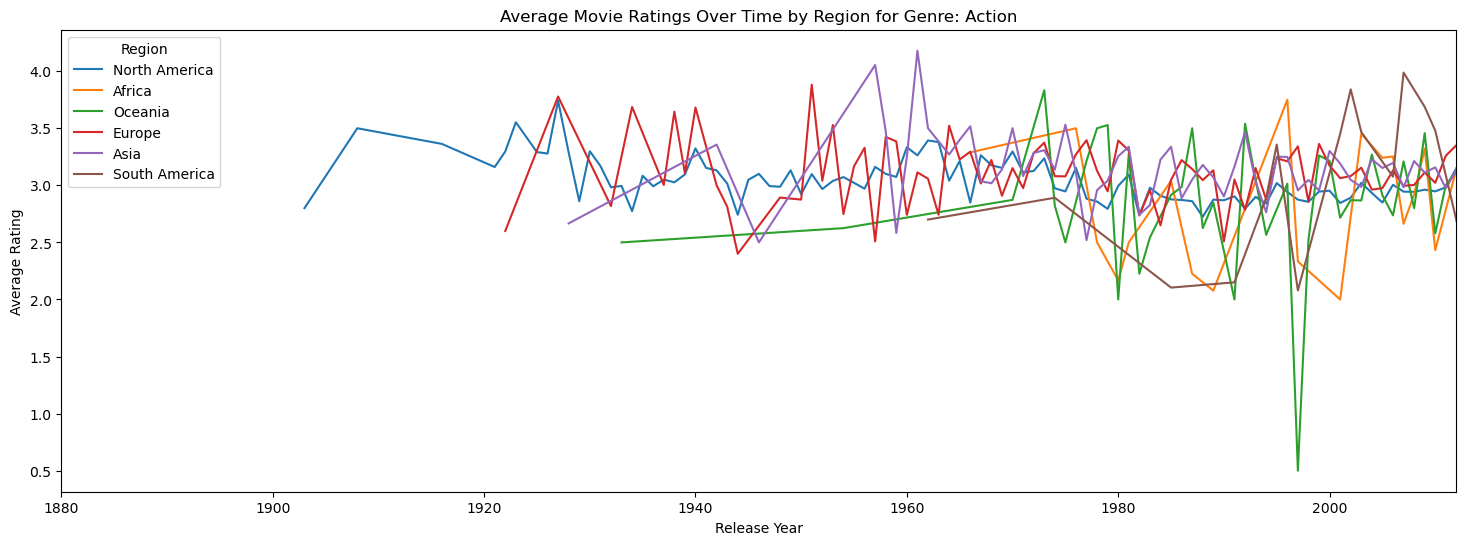

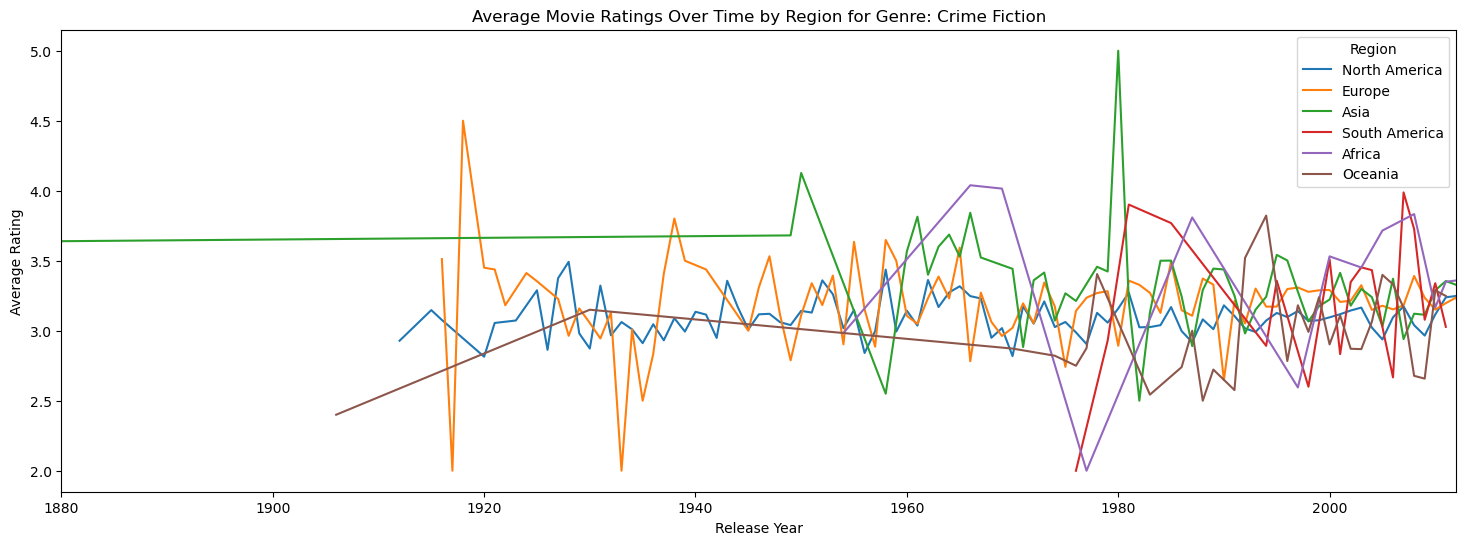

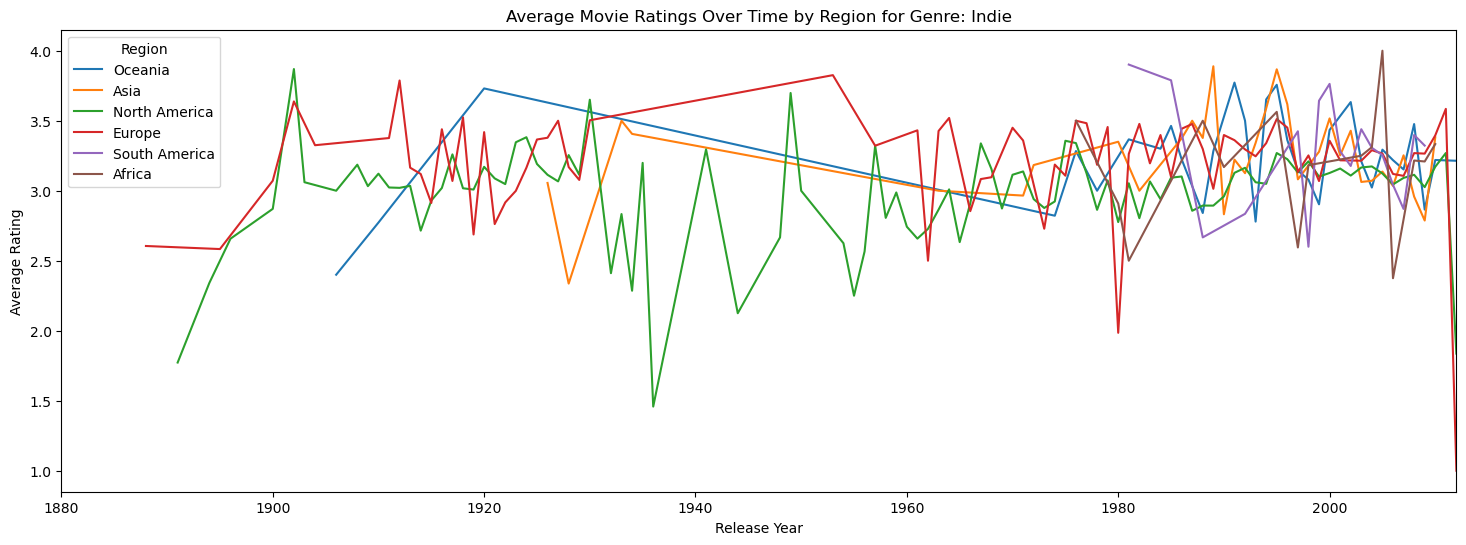

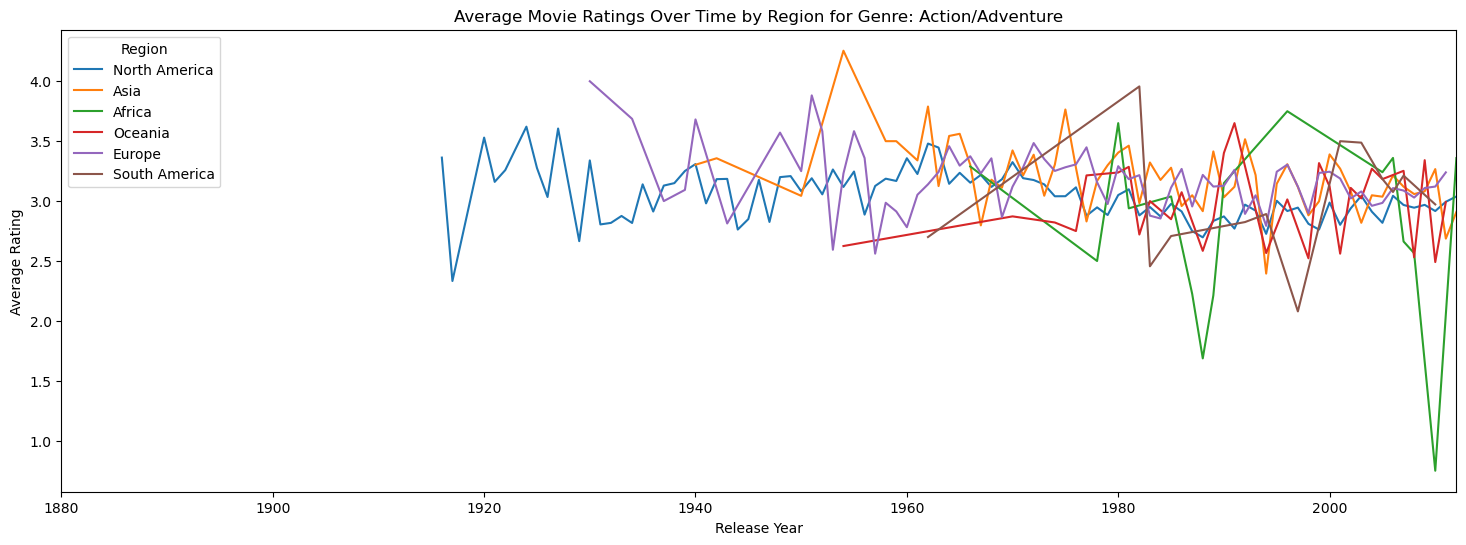

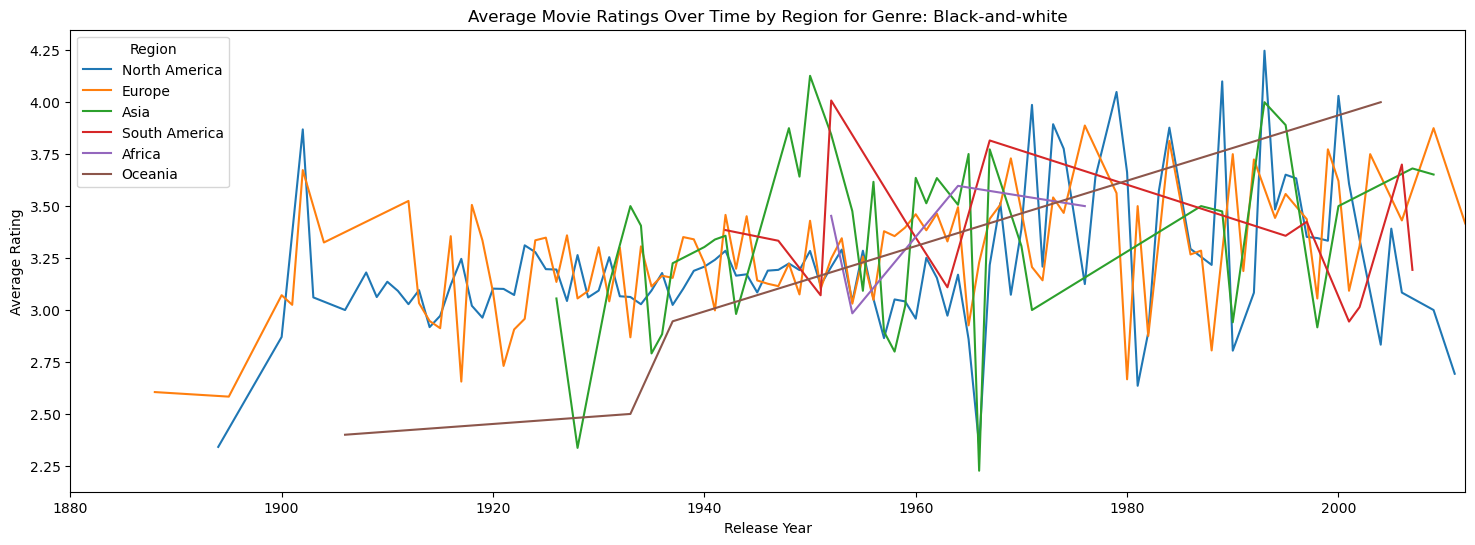

In [84]:
# Calculate the top 10 genres based on the count of movies in each genre
top_genres = df_movies_ratings_regions['genres'].value_counts().head(10).index

# Filter the data to include only movies from the top 10 genres
df_top_genres = df_movies_ratings_regions[df_movies_ratings_regions['genres'].isin(top_genres)]

# Loop over the top 10 genres and create individual plots
for genre in top_genres:
    # Filter data for each genre
    df_genre = df_top_genres[df_top_genres['genres'] == genre]
    
    plt.figure(figsize=(18, 6))
    sns.lineplot(data=df_genre, x='release_date', y='mean_rating', hue='region', estimator='mean',errorbar=None)
    plt.title(f"Average Movie Ratings Over Time by Region for Genre: {genre}")
    plt.xlabel("Release Year")
    plt.xlim(1880, 2012)
    plt.ylabel("Average Rating")
    plt.legend(title="Region")
    plt.show()

In [85]:

# Check for normality of ratings by region
for region in df_movies_ratings_regions['region'].unique():
    region_ratings = df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]['mean_rating']
    p_value = stats.kstest(region_ratings, 'norm')[1]
    print(f"Normality test for {region} ratings p-value: {p_value}")

Normality test for North America ratings p-value: 0.0
Normality test for Oceania ratings p-value: 0.0
Normality test for Asia ratings p-value: 0.0
Normality test for Europe ratings p-value: 0.0
Normality test for Africa ratings p-value: 0.0
Normality test for South America ratings p-value: 0.0


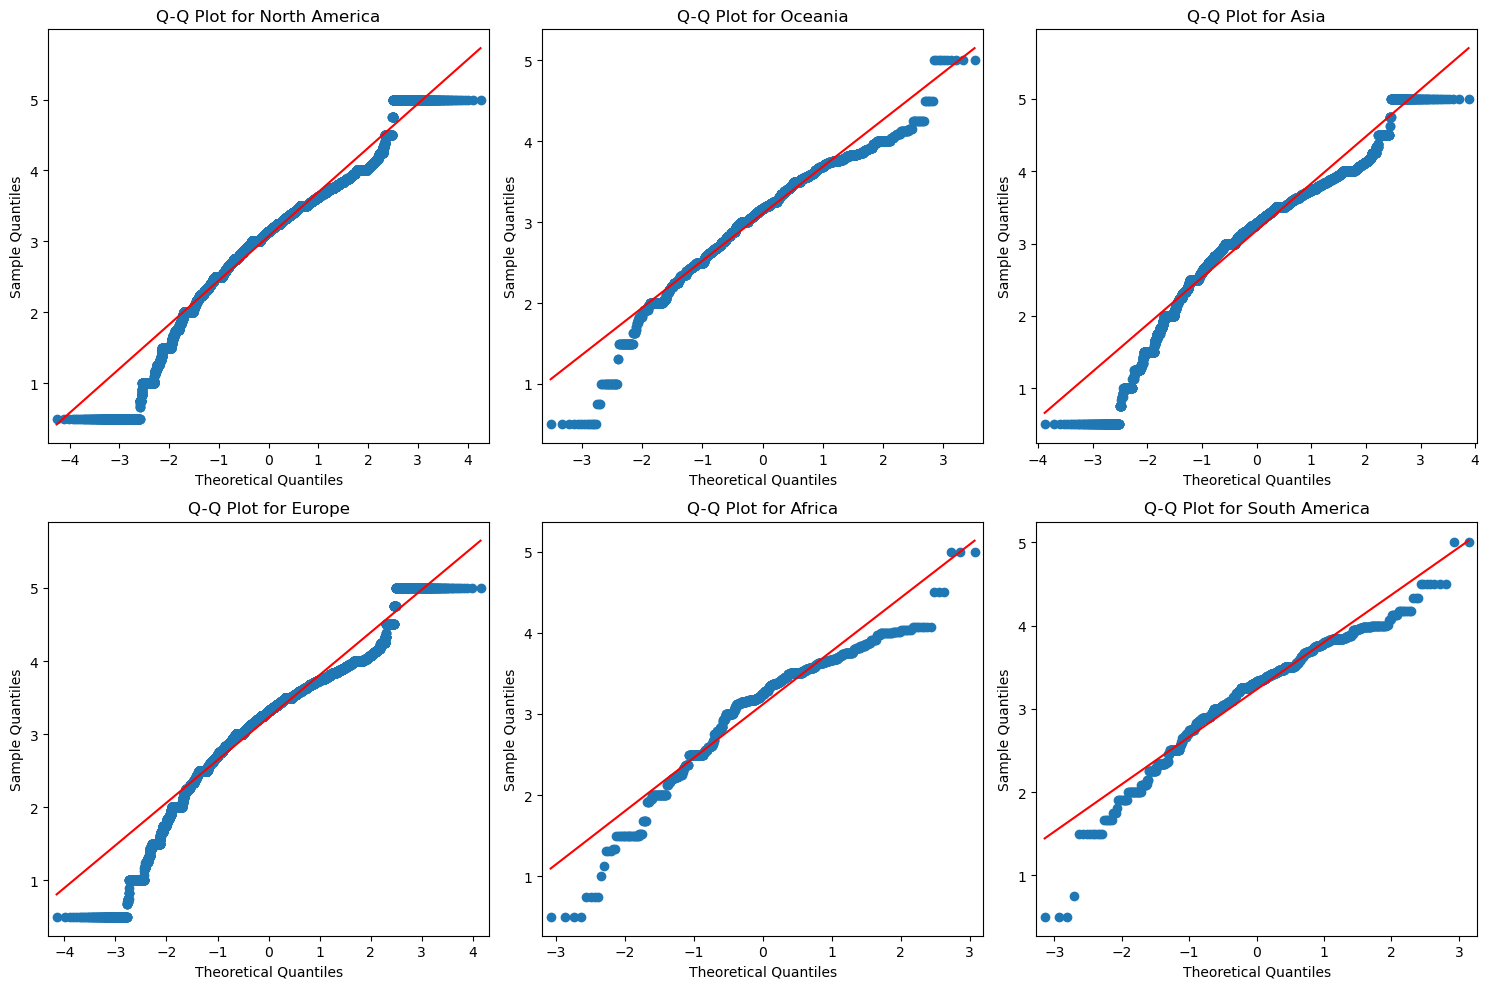

In [86]:
# Set up the layout for multiple Q-Q plots
plt.figure(figsize=(15, 10))
rows = (len(regions) + 2) // 3  

for i, region in enumerate(regions, 1):
    plt.subplot(rows, 3, i)
    region_data = df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]['mean_rating']
    
    # Create Q-Q plot
    sm.qqplot(region_data, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot for {region}')
    
plt.tight_layout()
plt.show()

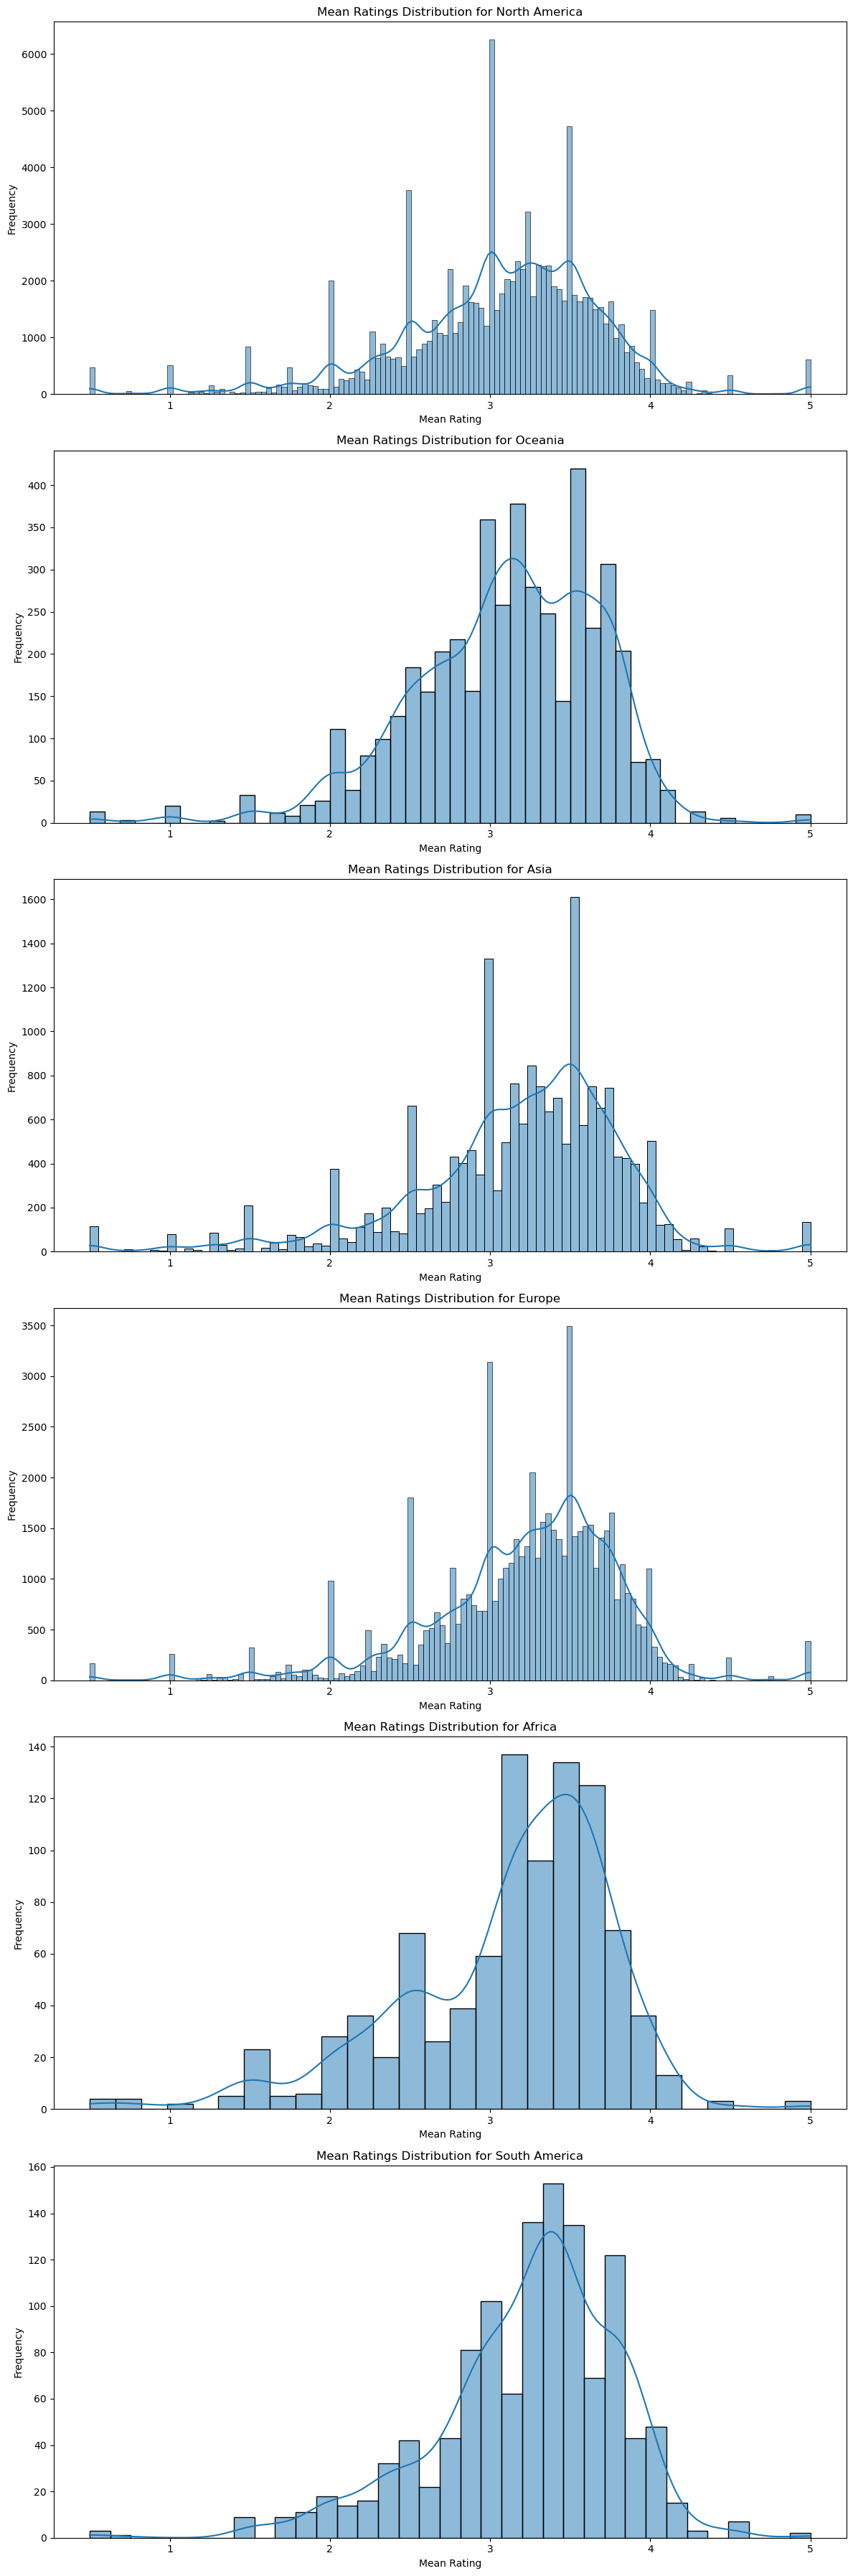

In [87]:
num_regions = len(regions)

fig, axes = plt.subplots(num_regions, 1, figsize=(12, 6 * num_regions))

for i, region in enumerate(regions):
    ax = axes[i] if num_regions > 1 else axes
    region_data = df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]
    sns.histplot(region_data['mean_rating'], kde=True, ax=ax)
    ax.set_title(f'Mean Ratings Distribution for {region}')
    ax.set_xlabel('Mean Rating')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [88]:
# Compare ratings between North America and Europe
na_ratings = df_movies_ratings_regions[df_movies_ratings_regions['region'] == 'North America']['mean_rating']
eu_ratings = df_movies_ratings_regions[df_movies_ratings_regions['region'] == 'Europe']['mean_rating']

# T-test
t_stat, p_value = stats.ttest_ind(na_ratings, eu_ratings)
print(f"T-test between North America and Europe ratings: t-stat = {t_stat}, p-value = {p_value}")

T-test between North America and Europe ratings: t-stat = -49.382457392429224, p-value = 0.0


In [89]:
# Encode region as a categorical variable
df_movies_ratings_regions['region'] = pd.Categorical(df_movies_ratings_regions['region'], categories=['North America'] + [cat for cat in df_movies_ratings_regions['region'].unique() if cat != 'North America'])

# Fit the linear regression model
model = smf.ols('mean_rating ~ C(region)', data=df_movies_ratings_regions)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     512.8
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        02:49:03   Log-Likelihood:            -1.7015e+05
No. Observations:              183396   AIC:                         3.403e+05
Df Residuals:                  183390   BIC:                         3.404e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [90]:
# ANOVA to compare mean ratings across multiple regions
rating_groups = [df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]['mean_rating'] for region in regions]

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"ANOVA across regions: F-stat = {f_stat}, p-value = {p_value}")


ANOVA across regions: F-stat = 512.8068183380353, p-value = 0.0


In [91]:
# Calculate Pearson's correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.pearsonr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['runtime'])
print(f"Pearson correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")

# Calculate Pearson's correlation between mean_rating and revenue
corr_revenue, p_value_revenue = stats.pearsonr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['revenue'])
print(f"Pearson correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# Calculate Pearson's correlation between mean_rating and year
corr_revenue, p_value_release_date = stats.pearsonr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['release_date'])
print(f"Pearson correlation between Ratings and Release_date: corr = {corr_revenue}, p-value = {p_value_release_date}")

Pearson correlation between Ratings and Runtime: corr = 0.1237573141593763, p-value = 0.0
Pearson correlation between Ratings and Revenue: corr = 0.059187554113448435, p-value = 5.546963871321411e-142
Pearson correlation between Ratings and Release_date: corr = -0.016828016974257703, p-value = 5.719007058156187e-13


In [92]:
#Linear Regression to predict ratings based on movie attributes
mod = smf.ols(formula='mean_rating ~ release_date + runtime + revenue', data=df_movies_ratings_regions)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1237.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        02:49:03   Log-Likelihood:            -1.6958e+05
No. Observations:              183396   AIC:                         3.392e+05
Df Residuals:                  183392   BIC:                         3.392e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.3353      0.113     47.032   

In [93]:
# Center the predictors by subtracting the mean
df_movies_ratings_regions['release_date_centered'] = df_movies_ratings_regions['release_date'] - df_movies_ratings_regions['release_date'].mean()
df_movies_ratings_regions['runtime_centered'] = df_movies_ratings_regions['runtime'] - df_movies_ratings_regions['runtime'].mean()
df_movies_ratings_regions['revenue_centered'] = df_movies_ratings_regions['revenue'] - df_movies_ratings_regions['revenue'].mean()

# Now fit the model using the centered predictors
mod_centered = smf.ols(formula='mean_rating ~ release_date_centered + runtime_centered + revenue_centered', data=df_movies_ratings_regions)
res_centered = mod_centered.fit()

print(res_centered.summary())

                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1237.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        02:49:03   Log-Likelihood:            -1.6958e+05
No. Observations:              183396   AIC:                         3.392e+05
Df Residuals:                  183392   BIC:                         3.392e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.13

In [102]:
# Non-parametric test: Mann-Whitney U test (alternative to T-test)
na_ratings = df_movies_ratings_regions[df_movies_ratings_regions['region'] == 'North America']['mean_rating']
eu_ratings = df_movies_ratings_regions[df_movies_ratings_regions['region'] == 'Europe']['mean_rating']

# Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(na_ratings, eu_ratings)
print(f"Mann-Whitney U test between North America and Europe ratings: U-stat = {u_stat}, p-value = {p_value}")

# Non-parametric test: Kruskal-Wallis H test (alternative to ANOVA)
regions = df_movies_ratings_regions['region'].unique()
rating_groups = [df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]['mean_rating'] for region in regions]

# Kruskal-Wallis H test
h_stat, p_value = stats.kruskal(*rating_groups)
print(f"Kruskal-Wallis test across regions: H-stat = {h_stat}, p-value = {p_value}")

# Non-parametric test: Spearman's rank correlation (alternative to Pearson's correlation)

# Calculate Spearman's rank correlation between mean_rating and runtime
corr_runtime, p_value_runtime = stats.spearmanr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['runtime'])
print(f"Spearman correlation between Ratings and Runtime: corr = {corr_runtime}, p-value = {p_value_runtime}")

# Calculate Spearman's rank correlation between mean_rating and revenue
corr_revenue, p_value_revenue = stats.spearmanr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['revenue'])
print(f"Spearman correlation between Ratings and Revenue: corr = {corr_revenue}, p-value = {p_value_revenue}")

# Calculate Spearman's rank correlation between mean_rating and release_date
corr_release_date, p_value_release_date = stats.spearmanr(df_movies_ratings_regions['mean_rating'], df_movies_ratings_regions['release_date'])
print(f"Spearman correlation between Ratings and Release_date: corr = {corr_release_date}, p-value = {p_value_release_date}")

Mann-Whitney U test between North America and Europe ratings: U-stat = 2441899431.0, p-value = 0.0
Kruskal-Wallis test across regions: H-stat = 3327.6089753583374, p-value = 0.0
Spearman correlation between Ratings and Runtime: corr = 0.17245298169992007, p-value = 0.0
Spearman correlation between Ratings and Revenue: corr = 0.09188913763596102, p-value = 0.0
Spearman correlation between Ratings and Release_date: corr = -0.015143262588791222, p-value = 8.850057475760067e-11


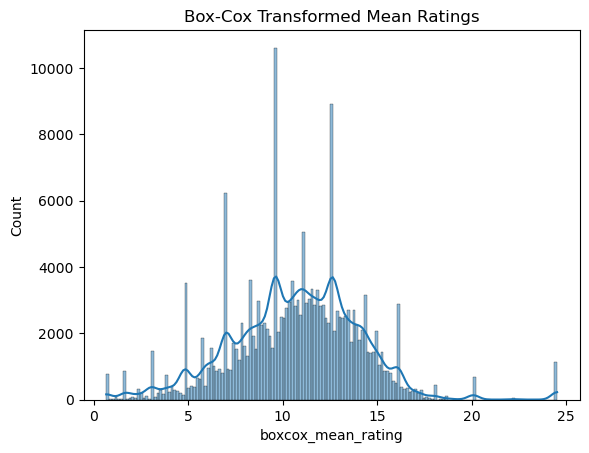

Normality test for Box-Cox transformed ratings p-value: 1.8216230605386393e-79


C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 183396.
  res = hypotest_fun_out(*samples, **kwds)


In [103]:
from scipy.stats import boxcox

# Box-Cox requires positive data, so ensure there are no zero or negative ratings
df_movies_ratings_regions['boxcox_mean_rating'], lambda_ = boxcox(df_movies_ratings_regions['mean_rating'] + 1)

# Check the distribution after Box-Cox transformation
sns.histplot(df_movies_ratings_regions['boxcox_mean_rating'], kde=True)
plt.title('Box-Cox Transformed Mean Ratings')
plt.show()

# Perform a normality test on the transformed data
stat, p_value = stats.shapiro(df_movies_ratings_regions['boxcox_mean_rating'])
print(f"Normality test for Box-Cox transformed ratings p-value: {p_value}")

C:\Users\ac\AppData\Local\Temp\ipykernel_2080\965546133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['boxcox_mean_rating'], lambda_ = boxcox(region_data['mean_rating'] + 1)
C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 97580.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\ac\AppData\Local\Temp\ipykernel_2080\965546133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Normality test for Box-Cox transformed ratings for North America p-value: 1.5091736996812736e-67
Normality test for Box-Cox transformed ratings for Oceania p-value: 2.6133005770202077e-17


C:\Users\ac\AppData\Local\Temp\ipykernel_2080\965546133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['boxcox_mean_rating'], lambda_ = boxcox(region_data['mean_rating'] + 1)
C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19145.
  res = hypotest_fun_out(*samples, **kwds)


Normality test for Box-Cox transformed ratings for Asia p-value: 1.889562355094728e-45


C:\Users\ac\AppData\Local\Temp\ipykernel_2080\965546133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['boxcox_mean_rating'], lambda_ = boxcox(region_data['mean_rating'] + 1)
C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 59981.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\ac\AppData\Local\Temp\ipykernel_2080\965546133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Normality test for Box-Cox transformed ratings for Europe p-value: 1.795533116155453e-66
Normality test for Box-Cox transformed ratings for Africa p-value: 4.331376802849005e-12
Normality test for Box-Cox transformed ratings for South America p-value: 3.0451989450385476e-07


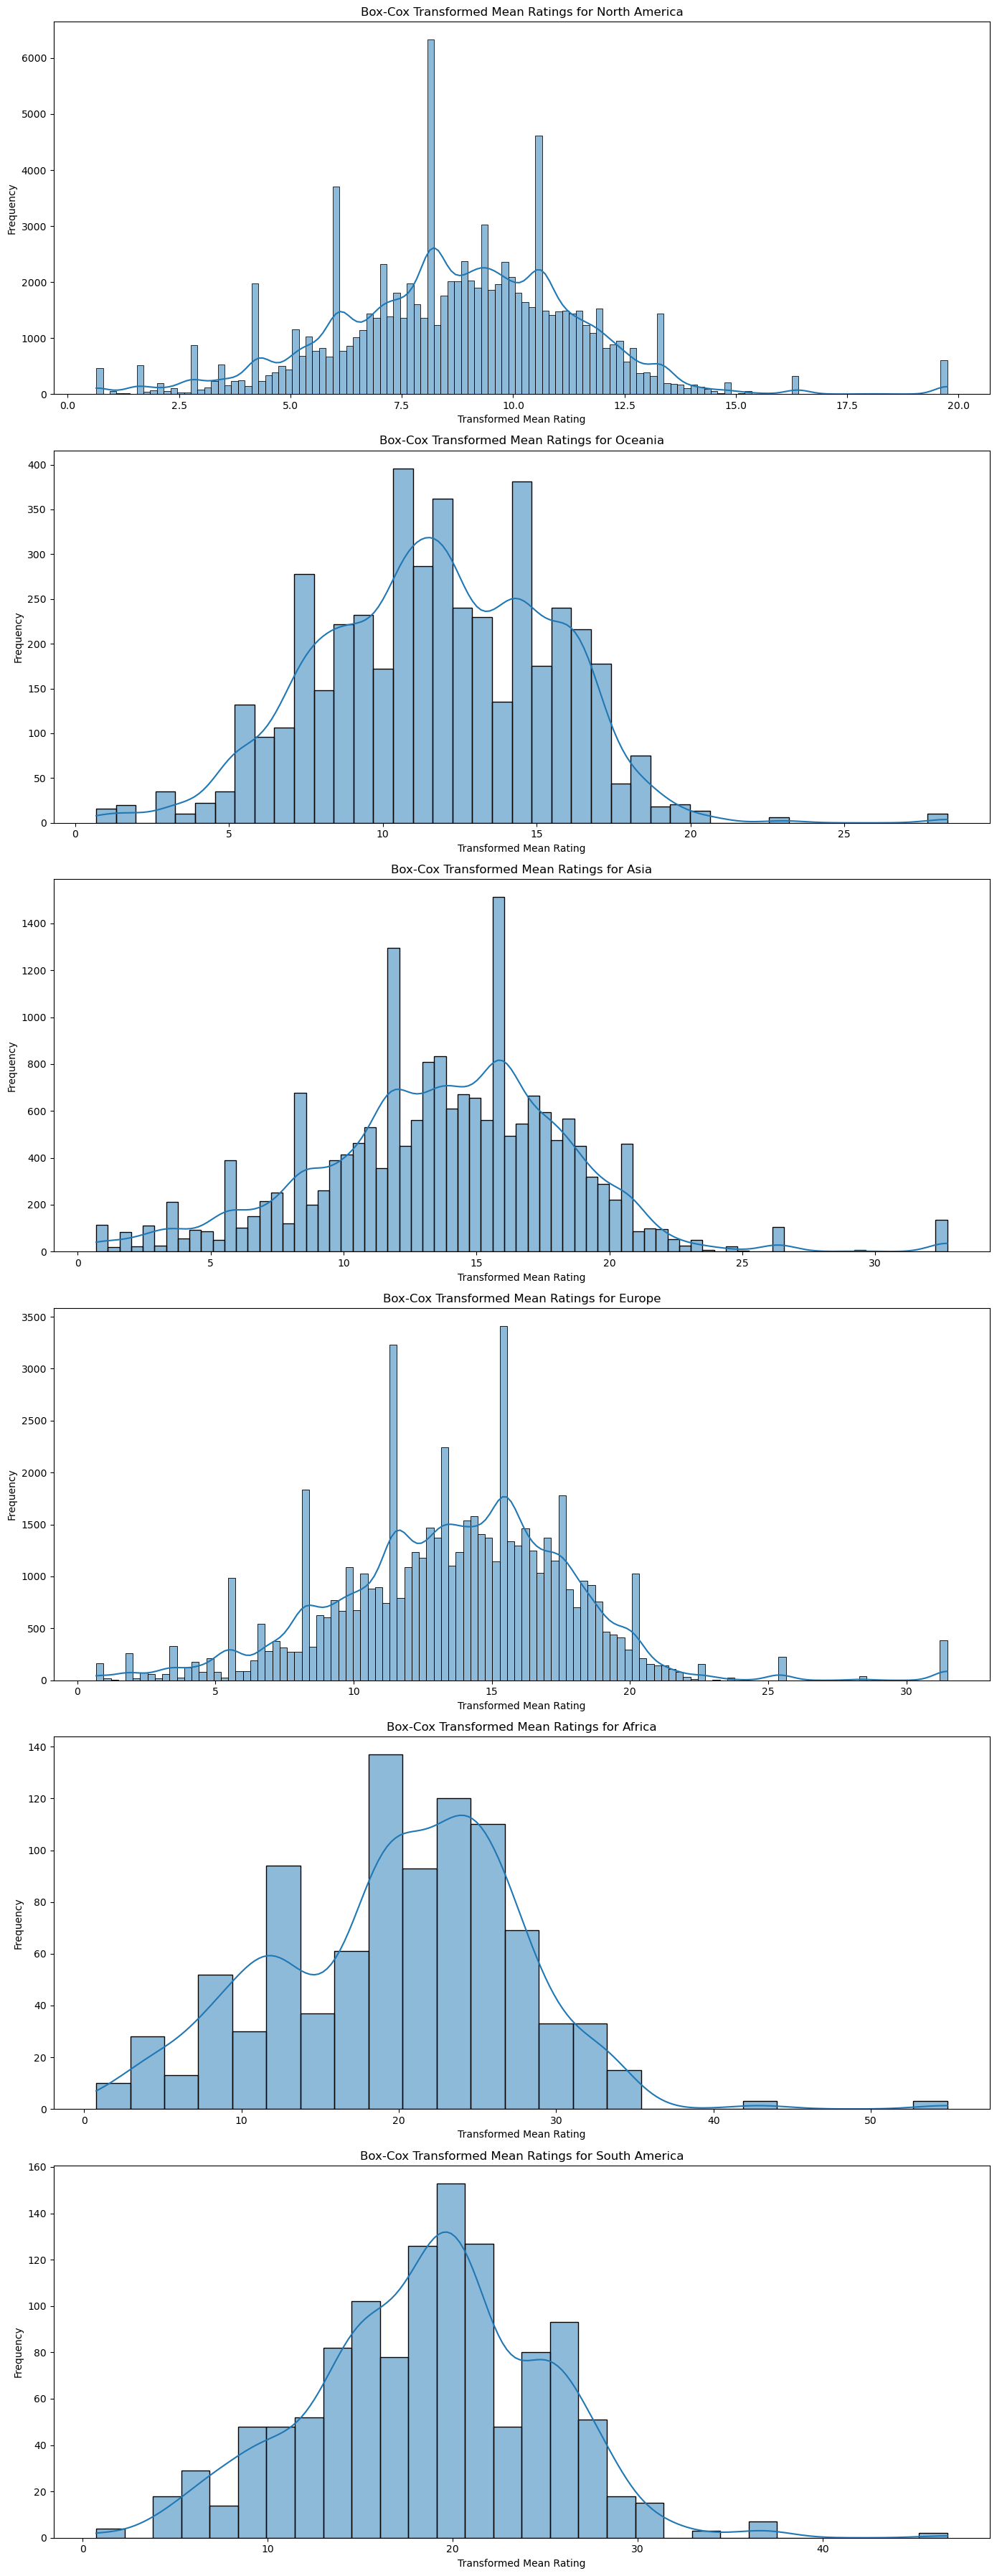

In [104]:
fig, axes = plt.subplots(len(regions), 1, figsize=(14, 6 * len(regions)))

# Loop through each region to apply Box-Cox transformation and normality test
for i, region in enumerate(regions):
    
    ax = axes[i] if len(regions) > 1 else axes
    region_data = df_movies_ratings_regions[df_movies_ratings_regions['region'] == region]
    
    # Apply Box-Cox transformation (ensure positive data by adding 1)
    region_data['boxcox_mean_rating'], lambda_ = boxcox(region_data['mean_rating'] + 1)
    
    # Plot the transformed ratings
    sns.histplot(region_data['boxcox_mean_rating'], kde=True, ax=ax)
    ax.set_title(f'Box-Cox Transformed Mean Ratings for {region}')
    ax.set_xlabel('Transformed Mean Rating')
    ax.set_ylabel('Frequency')

    # Perform normality test (Shapiro-Wilk test) on the transformed data
    stat, p_value = stats.shapiro(region_data['boxcox_mean_rating'])
    print(f"Normality test for Box-Cox transformed ratings for {region} p-value: {p_value}")

plt.tight_layout()
plt.show()

In [211]:
# Filter data for Latin America region
la_data = df_movies_ratings_regions[df_movies_ratings_regions['region'] == 'South America']

# Ensure there are no zero or negative values, as Box-Cox requires positive values
la_data['mean_rating'] = la_data['mean_rating'] + 1  # To avoid zero/negative ratings

# Apply Box-Cox transformation to mean_rating
la_data['boxcox_mean_rating'], lambda_ = boxcox(la_data['mean_rating'])

# Define the independent variables (covariates) and dependent variable (Box-Cox transformed mean ratings)
X = la_data[['revenue', 'release_date', 'runtime']] 
y = la_data['boxcox_mean_rating']  

# Add a constant (intercept) to the model
X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     boxcox_mean_rating   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     25.80
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           3.58e-16
Time:                        04:37:04   Log-Likelihood:                -3850.4
No. Observations:                1198   AIC:                             7709.
Df Residuals:                    1194   BIC:                             7729.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -15.7445     24.129     -0.653   

C:\Users\ac\AppData\Local\Temp\ipykernel_2080\1073246495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_data['mean_rating'] = la_data['mean_rating'] + 1  # To avoid zero/negative ratings
C:\Users\ac\AppData\Local\Temp\ipykernel_2080\1073246495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_data['boxcox_mean_rating'], lambda_ = boxcox(la_data['mean_rating'])


In [111]:
region_time_series = df_movies_ratings_regions.groupby(['release_date', 'region'])['mean_rating'].mean().reset_index()
region_time_series = region_time_series.dropna(subset=['mean_rating'])
# Check the difference between consecutive release dates for each region
for region in regions:
    region_data = region_time_series[region_time_series['region'] == region].sort_values(by='release_date')
    date_diff = region_data['release_date'].diff().dropna()
    print(f"Gaps for {region}:")
    print(date_diff.describe())  # This will tell you the range of gaps between consecutive release dates


Gaps for Asia:
count     93.000000
mean      10.849462
std       92.478311
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      893.000000
Name: release_date, dtype: float64
Gaps for North America:
count    123.000000
mean       1.146341
std        1.029746
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       12.000000
Name: release_date, dtype: float64
Gaps for Europe:
count    125.00000
mean       1.04800
std        0.37794
min        1.00000
25%        1.00000
50%        1.00000
75%        1.00000
max        5.00000
Name: release_date, dtype: float64
Gaps for Oceania:
count    66.000000
mean      1.681818
std       1.815820
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      10.000000
Name: release_date, dtype: float64
Gaps for South America:
count    62.000000
mean      1.451613
std       1.422044
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max  

In [213]:
from statsmodels.tsa.stattools import adfuller

# Conduct ADF test for each region, ordered by release_date
regions = region_time_series['region'].unique()
adf_results = {}

for region in regions:
    # Filter and sort by release_date to maintain time order
    region_data = region_time_series[region_time_series['region'] == region].sort_values(by='release_date')['mean_rating']
    adf_result = adfuller(region_data)  # Drop any NaN values for ADF test
    p_value = adf_result[1]
    adf_results[region] = p_value
    print(f"ADF Test for {region} - p-value: {p_value}")


ADF Test for Asia - p-value: 0.001268852246877134
ADF Test for North America - p-value: 6.364117811459374e-05
ADF Test for Europe - p-value: 1.3372105875963504e-13
ADF Test for Oceania - p-value: 0.004195840292055155
ADF Test for South America - p-value: 1.4886572179921126e-11
ADF Test for Africa - p-value: 4.977394048568162e-09


In [189]:
# Filter data for the 'Africa' region, sort by 'release_date', and set 'release_date' as the index
af_region_time_series = region_time_series[region_time_series['region'] == 'Africa'].sort_values(by='release_date')
af_region_time_series.set_index('release_date', inplace=True)

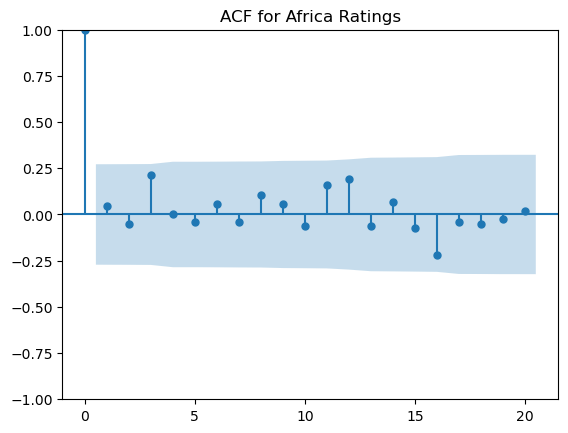

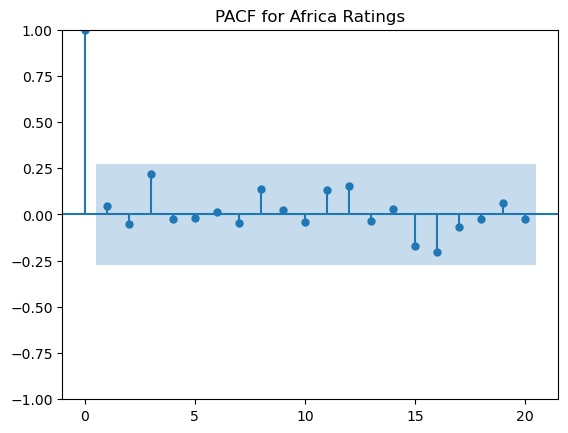

In [190]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

af_ratings = af_region_time_series['mean_rating']

# Plot ACF for Africa
plot_acf(af_ratings, lags=20)
plt.title("ACF for Africa Ratings")
plt.show()

# Plot PACF for Africa
plot_pacf(af_ratings, lags=20)
plt.title("PACF for Africa Ratings")
plt.show()

C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            mean_rating   No. Observations:                   52
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 -22.660
Date:                Tue, 12 Nov 2024   AIC                             59.321
Time:                        04:19:45   BIC                             72.980
Sample:                             0   HQIC                            64.557
                                 - 52                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1641      0.071     44.805      0.000       3.026       3.303
ar.L1          0.0687      0.503      0.137      0.891      -0.917       1.054
ar.L2         -0.5265      0.493     -1.068      0.2

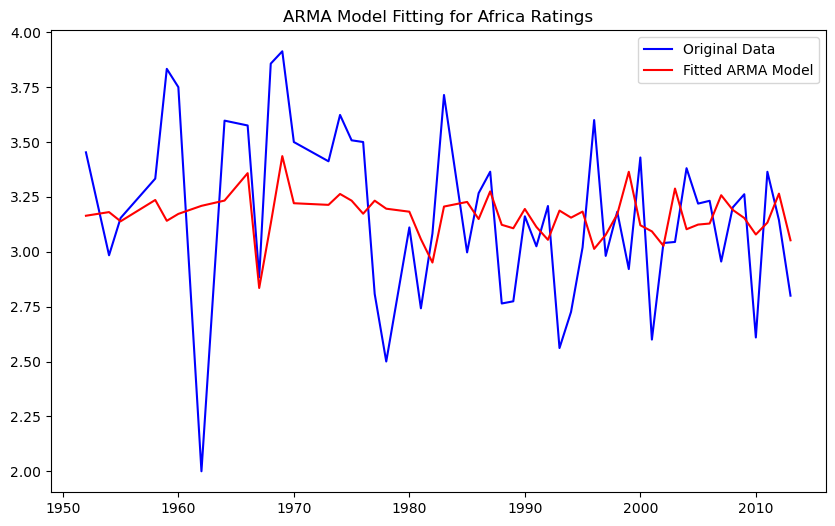

In [196]:
from statsmodels.tsa.arima.model import ARIMA
p = 2  # AR order
q = 3 # MA order

# Fit the ARMA model
arma_model = ARIMA(af_ratings, order=(p, 0, q))  # d=0 for ARMA model (no differencing)
fitted_model = arma_model.fit()

print(fitted_model.summary())

# Plot the fitted values and original data
plt.figure(figsize=(10, 6))
plt.plot(af_ratings, label="Original Data", color='blue')
plt.plot(fitted_model.fittedvalues, label="Fitted ARMA Model", color='red')
plt.title("ARMA Model Fitting for Africa Ratings")
plt.legend()
plt.show()

C:\Users\ac\anaconda3\envs\projectADA\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


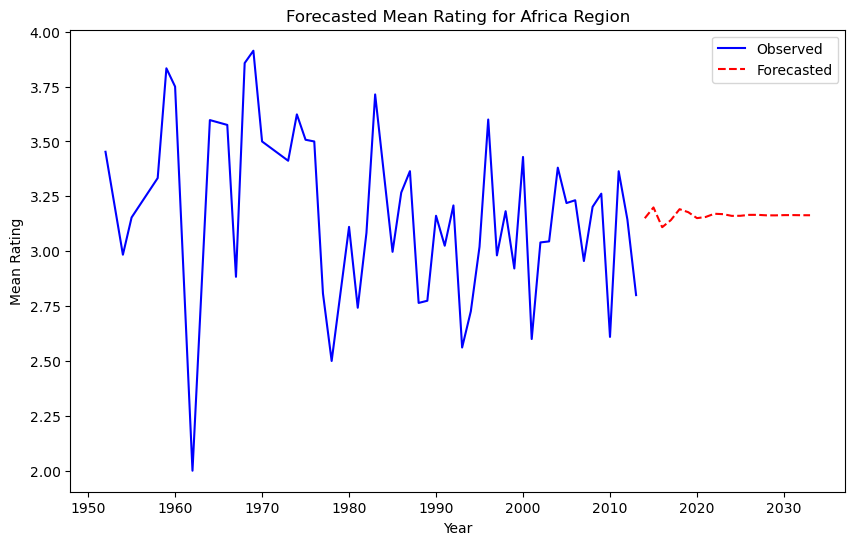

In [209]:
# Forecast the next 'forecast_steps' time steps
forecast_steps = 20  # Example: Forecast the next 10 time steps
forecast = fitted_model.forecast(steps=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(af_region_time_series.index, af_region_time_series['mean_rating'], label='Observed', color='blue')

# Create the forecasted range based on the last observed year
last_year = af_region_time_series.index[-1]  # Last year from your time series data
forecast_dates = pd.date_range(start=str(last_year + 1), periods=forecast_steps, freq='YE-DEC').year

plt.plot(forecast_dates, forecast, label='Forecasted', color='red', linestyle='--')

plt.title('Forecasted Mean Rating for Africa Region')
plt.xlabel('Year')
plt.ylabel('Mean Rating')
plt.legend()


In [ ]:
import pmdarima as pm

# Fit the AutoARIMA model to the data
auto_model = pm.auto_arima(af_ratings, seasonal=False, stepwise=True, trace=True)

# Get the best p, d, q values and the corresponding AIC
print(f"Best Model: {auto_model.summary()}")

# Plot the original and fitted values
plt.figure(figsize=(10, 6))
plt.plot(af_ratings, label="Original Data", color='blue')
plt.plot(auto_model.fittedvalues(), label="Fitted AutoARIMA", color='red')
plt.title("AutoARIMA Model Fit")
plt.legend()
plt.show()